# Μοντελοποίηση: Ταξινόμηση Κατανάλωσης Ενέργειας

## Στόχος
Πρόβλεψη εάν η ημερήσια κατανάλωση ενέργειας είναι **Υψηλή** ή **Χαμηλή** σε σχέση με τον εποχιακό μέσο όρο του νοικοκυριού.

## Προσέγγιση
- **Target**: Season-adjusted high consumption (>15% πάνω από εποχιακό μέσο όρο)
- **Features**: Μόνο past-known features (lags, rolling stats, calendar)
- **Μοντέλα**: Logistic Regression → Random Forest → XGBoost/LightGBM
- **Αξιολόγηση**: Accuracy, Precision, Recall, F1-Score, ROC-AUC

## Αποφυγή Data Leakage
✅ Χρήση μόνο features που είναι γνωστά **πριν** την ημέρα πρόβλεψης  
✅ Season means υπολογίζονται **μόνο από train set**  
✅ Scalers fit **μόνο στο train**

---
## 1. Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    RocCurveDisplay
)

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

DATA_DIR = Path('..') / 'data'
RESULTS_DIR = Path('..') / 'results'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print('✅ Imports completed successfully')
print(f'📁 Data directory: {DATA_DIR.absolute()}')
print(f'📊 Results directory: {RESULTS_DIR.absolute()}')

✅ Imports completed successfully
📁 Data directory: /home/konstantinos-papadogiannis/energy-data-mining/notebooks/../data
📊 Results directory: /home/konstantinos-papadogiannis/energy-data-mining/notebooks/../results


---
## 2. Φόρτωση Δεδομένων

Φορτώνουμε τα **raw** (μη κανονικοποιημένα) ημερήσια δεδομένα από το preprocessing.

In [2]:
# Φόρτωση train/val/test sets
train = pd.read_csv(DATA_DIR / 'train_raw.csv', parse_dates=True, index_col=0)
val = pd.read_csv(DATA_DIR / 'val_raw.csv', parse_dates=True, index_col=0)
test = pd.read_csv(DATA_DIR / 'test_raw.csv', parse_dates=True, index_col=0)

print('📊 Dataset Shapes:')
print(f'  Train: {train.shape} ({train.index.min().date()} → {train.index.max().date()})')
print(f'  Val:   {val.shape} ({val.index.min().date()} → {val.index.max().date()})')
print(f'  Test:  {test.shape} ({test.index.min().date()} → {test.index.max().date()})')

print('\n📋 Available columns:', train.shape[1])
print('\n🔍 First 3 rows of train:')
train.head(3)

📊 Dataset Shapes:
  Train: (987, 48) (2007-01-15 → 2009-09-27)
  Val:   (210, 48) (2009-09-29 → 2010-04-26)
  Test:  (213, 48) (2010-04-28 → 2010-11-26)

📋 Available columns: 48

🔍 First 3 rows of train:


,Daily_total_power,Daily_mean_power,Daily_peak_power,Daily_min_power,Daily_std_power,Global_reactive_power_sum,Global_reactive_power_mean,Voltage_mean,Voltage_std,Global_intensity_mean,Global_intensity_max,Sub_metering_1_sum,Sub_metering_2_sum,Sub_metering_3_sum,Peak_hour_power,Nighttime_usage,Morning_usage,Afternoon_usage,DayOfWeek,IsWeekend,Month,Season,Year,DayOfYear,lag_1,lag_7,lag_14,lag_30,rolling_mean_7d,rolling_std_7d,rolling_median_7d,rolling_min_7d,rolling_max_7d,ema_7d,ema_30d,diff_1d,diff_7d,Total_submetering,Sub1_ratio,Sub2_ratio,Sub3_ratio,Other_consumption,Power_factor,Peak_to_total_ratio,Night_to_total_ratio,Morning_to_total_ratio,Next_day_consumption,High_Consumption
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-01-15,35.811,1.492,5.896,0.208,0.961,2.914,0.121,241.241,3.098,6.262,25.2,1099.0,2239.0,15163.0,9.586,8.330,9.671,8.225,0,0,1,Winter,2007,15,50.184,37.356,45.817,20.153,38.523,10.108,37.356,24.355,53.114,41.327,37.364,-14.373,-1.545,18501.0,0.031,0.063,0.423,17.310,0.925,0.268,0.233,0.270,28.107,0
2007-01-16,28.107,1.171,5.570,0.212,0.996,3.090,0.129,241.945,2.711,4.976,23.2,2063.0,644.0,6583.0,7.885,3.826,6.198,10.197,1,0,1,Winter,2007,16,35.811,31.151,21.154,56.508,38.302,10.154,35.913,24.355,53.114,39.948,37.264,-7.705,-3.044,9290.0,0.073,0.023,0.234,18.817,0.901,0.281,0.136,0.221,47.461,0
2007-01-17,47.461,1.978,8.000,0.206,1.438,3.346,0.139,241.005,2.781,8.284,34.2,3500.0,5737.0,16064.0,11.041,6.900,15.991,13.530,2,0,1,Winter,2007,17,28.107,35.913,16.901,36.730,37.867,10.568,35.913,24.355,53.114,36.988,36.673,19.355,11.548,25301.0,0.074,0.121,0.338,22.160,0.934,0.233,0.145,0.337,30.358,1


---
## 3. Ορισμός Target: Season-Adjusted High Consumption

### Γιατί Season-Adjusted;
Η κατανάλωση ενέργειας εξαρτάται **πολύ** από την εποχή:
- **Χειμώνας**: ~33 kWh/day (θέρμανση)
- **Καλοκαίρι**: ~17 kWh/day (χωρίς θέρμανση)

Αν χρησιμοποιήσουμε **έναν** μέσο όρο για όλο το χρόνο, όλες οι χειμωνιάτικες μέρες θα είναι "high" και όλες οι καλοκαιρινές "low", που δεν είναι χρήσιμο.

### Λύση
Συγκρίνουμε κάθε μέρα με τον **εποχιακό** μέσο όρο της:
- **High Consumption** = Κατανάλωση > 1.15 × εποχιακός μέσος όρος (15% πάνω)
- **Normal/Low Consumption** = Κατανάλωση ≤ 1.15 × εποχιακός μέσος όρος

### Αποφυγή Data Leakage
✅ Υπολογίζουμε τους εποχιακούς μέσους **μόνο από το train set**  
✅ Εφαρμόζουμε τους ίδιους μέσους στο val και test

In [3]:
# Υπολογισμός εποχιακών μέσων όρων ΑΠΟ TRAIN ΜΟΝΟ
season_means = train.groupby('Season')['Daily_total_power'].mean()

print('📊 Εποχιακοί Μέσοι Όροι Κατανάλωσης (από train set):')
print(season_means.sort_values(ascending=False).round(2))
print(f'\n📈 Διαφορά Winter vs Summer: {(season_means["Winter"] - season_means["Summer"]):.2f} kWh/day')
print(f'   Ποσοστό: {(season_means["Winter"] / season_means["Summer"] - 1)*100:.1f}% περισσότερο το χειμώνα')

📊 Εποχιακοί Μέσοι Όροι Κατανάλωσης (από train set):
Season
Winter    33.31
Autumn    27.02
Spring    26.46
Summer    17.21
Name: Daily_total_power, dtype: float64

📈 Διαφορά Winter vs Summer: 16.10 kWh/day
   Ποσοστό: 93.5% περισσότερο το χειμώνα


In [4]:
# Υπολογισμός season-adjusted deviation για κάθε set
THRESHOLD = 1.15  # 15% πάνω από εποχιακό μέσο = High

# Train
train['season_mean'] = train['Season'].map(season_means)
train['deviation_ratio'] = train['Daily_total_power'] / train['season_mean']
y_train = (train['deviation_ratio'] > THRESHOLD).astype(int)

# Validation (χρήση train season_means!)
val['season_mean'] = val['Season'].map(season_means)
val['deviation_ratio'] = val['Daily_total_power'] / val['season_mean']
y_val = (val['deviation_ratio'] > THRESHOLD).astype(int)

# Test (χρήση train season_means!)
test['season_mean'] = test['Season'].map(season_means)
test['deviation_ratio'] = test['Daily_total_power'] / test['season_mean']
y_test = (test['deviation_ratio'] > THRESHOLD).astype(int)

print(f'🎯 Target Definition: High Consumption = deviation_ratio > {THRESHOLD}')
print(f'   (i.e., >15% πάνω από τον εποχιακό μέσο όρο)\n')

print('📊 Target Distribution:')
print(f'  Train: {y_train.value_counts().to_dict()} → {y_train.value_counts(normalize=True).round(3).to_dict()}')
print(f'  Val:   {y_val.value_counts().to_dict()} → {y_val.value_counts(normalize=True).round(3).to_dict()}')
print(f'  Test:  {y_test.value_counts().to_dict()} → {y_test.value_counts(normalize=True).round(3).to_dict()}')

print('\n✅ Target is balanced (not too imbalanced)')

🎯 Target Definition: High Consumption = deviation_ratio > 1.15
   (i.e., >15% πάνω από τον εποχιακό μέσο όρο)

📊 Target Distribution:
  Train: {0: 703, 1: 284} → {0: 0.712, 1: 0.288}
  Val:   {0: 159, 1: 51} → {0: 0.757, 1: 0.243}
  Test:  {0: 153, 1: 60} → {0: 0.718, 1: 0.282}

✅ Target is balanced (not too imbalanced)


---
## 4. Επιλογή Features (Χωρίς Data Leakage)

### Κανόνας
Χρησιμοποιούμε **μόνο** features που είναι γνωστά **πριν** την ημέρα που θέλουμε να προβλέψουμε.

### ✅ Safe Features (OK to use)
1. **LAG features**: `lag_1`, `lag_7`, `lag_14`, `lag_30` (χθεσινή, προηγούμενης εβδομάδας κτλ)
2. **Rolling statistics**: `rolling_mean_7d`, `rolling_std_7d`, κτλ (υπολογισμένα από παρελθόν)
3. **EMA**: `ema_7d`, `ema_30d` (exponential moving average)
4. **Differences**: `diff_1d`, `diff_7d` (αλλαγές από χθες/προηγούμενη εβδομάδα)
5. **Calendar features**: `DayOfWeek`, `Month`, `Season`, `IsWeekend`, κτλ (γνωστά εκ των προτέρων)

### ❌ Forbidden Features (Data Leakage!)
- `Daily_total_power` (αυτό προσπαθούμε να προβλέψουμε!)
- `Daily_mean_power`, `Daily_peak_power` (same-day aggregates)
- `Peak_hour_power`, `Nighttime_usage` (same-day)
- `Total_submetering`, `Sub1_ratio`, κτλ (same-day)
- `Next_day_consumption` (μελλοντική τιμή!)

In [5]:
# Ορισμός safe features
safe_features = [
    # LAG features (past values)
    'lag_1', 'lag_7', 'lag_14', 'lag_30',
    
    # Rolling statistics (computed from past)
    'rolling_mean_7d', 'rolling_std_7d', 'rolling_median_7d',
    'rolling_min_7d', 'rolling_max_7d',
    
    # Exponential moving averages
    'ema_7d', 'ema_30d',
    
    # Differences (changes from past)
    'diff_1d', 'diff_7d',
    
    # Calendar features (known in advance)
    'DayOfWeek', 'IsWeekend', 'Month', 'Season', 'Year', 'DayOfYear'
]

# Έλεγχος ότι όλα τα features υπάρχουν
missing_features = [f for f in safe_features if f not in train.columns]
if missing_features:
    print(f'⚠️  Missing features: {missing_features}')
    safe_features = [f for f in safe_features if f in train.columns]

print(f'✅ Using {len(safe_features)} safe features (no data leakage):')
for i, f in enumerate(safe_features, 1):
    print(f'  {i:2d}. {f}')

✅ Using 19 safe features (no data leakage):
   1. lag_1
   2. lag_7
   3. lag_14
   4. lag_30
   5. rolling_mean_7d
   6. rolling_std_7d
   7. rolling_median_7d
   8. rolling_min_7d
   9. rolling_max_7d
  10. ema_7d
  11. ema_30d
  12. diff_1d
  13. diff_7d
  14. DayOfWeek
  15. IsWeekend
  16. Month
  17. Season
  18. Year
  19. DayOfYear


In [6]:
# Δημιουργία X (features) και y (target) με ευθυγράμμιση
X_train = train[safe_features].copy()
X_val = val[safe_features].copy()
X_test = test[safe_features].copy()

# Αφαίρεση NaN rows (από lag/rolling features)
train_mask = X_train.notna().all(axis=1)
X_train = X_train[train_mask]
y_train_aligned = y_train[train_mask]

val_mask = X_val.notna().all(axis=1)
X_val = X_val[val_mask]
y_val_aligned = y_val[val_mask]

test_mask = X_test.notna().all(axis=1)
X_test = X_test[test_mask]
y_test_aligned = y_test[test_mask]

print('📊 Final Dataset Shapes (after removing NaN):')
print(f'  X_train: {X_train.shape}, y_train: {y_train_aligned.shape}')
print(f'  X_val:   {X_val.shape}, y_val:   {y_val_aligned.shape}')
print(f'  X_test:  {X_test.shape}, y_test:  {y_test_aligned.shape}')

print('\n✅ No missing values in features')
print(f'✅ X and y are aligned (same indices)')

📊 Final Dataset Shapes (after removing NaN):
  X_train: (987, 19), y_train: (987,)
  X_val:   (210, 19), y_val:   (210,)
  X_test:  (213, 19), y_test:  (213,)

✅ No missing values in features
✅ X and y are aligned (same indices)


---
## 5. Preprocessing Pipeline

Δημιουργούμε pipeline που:
1. **OneHotEncoder** για categorical features (`Season`)
2. **StandardScaler** για numeric features
3. Fit **μόνο στο train**, transform σε train/val/test

In [7]:
# Διαχωρισμός σε categorical και numeric features
categorical_features = ['Season']
numeric_features = [f for f in safe_features if f not in categorical_features]

print(f'📊 Feature Types:')
print(f'  Categorical: {categorical_features}')
print(f'  Numeric: {len(numeric_features)} features')

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='drop'
)

print('\n✅ Preprocessing pipeline created')
print('   - OneHotEncoder for Season (4 categories → 4 binary columns)')
print('   - StandardScaler for numeric features (mean=0, std=1)')

📊 Feature Types:
  Categorical: ['Season']
  Numeric: 18 features

✅ Preprocessing pipeline created
   - OneHotEncoder for Season (4 categories → 4 binary columns)
   - StandardScaler for numeric features (mean=0, std=1)


In [8]:
# Helper function για αξιολόγηση μοντέλων
def evaluate_model(y_true, y_pred, y_proba, set_name=''):
    """Υπολογίζει και εκτυπώνει μετρικές αξιολόγησης"""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba)
    
    print(f'\n📊 {set_name} Set Results:')
    print(f'  Accuracy:  {acc*100:.2f}%')
    print(f'  Precision: {prec*100:.2f}%')
    print(f'  Recall:    {rec*100:.2f}%')
    print(f'  F1-Score:  {f1*100:.2f}%')
    print(f'  ROC-AUC:   {auc*100:.2f}%')
    
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': auc}

print('✅ Helper function defined')

✅ Helper function defined


---
---
# ΜΟΝΤΕΛΟ 1: Logistic Regression (Baseline)

## Γιατί Logistic Regression;
- ✅ **Γρήγορο** και απλό
- ✅ **Interpretable** (μπορούμε να δούμε τα coefficients)
- ✅ Καλό **baseline** για σύγκριση με πιο πολύπλοκα μοντέλα
- ✅ Λειτουργεί καλά όταν τα features είναι κανονικοποιημένα

## Παράμετροι
- `max_iter=1000`: Αρκετές επαναλήψεις για σύγκλιση
- `random_state=42`: Για reproducibility

In [9]:
# Δημιουργία pipeline: preprocessing + model
logistic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

print('🤖 Model: Logistic Regression')
print('   Parameters: max_iter=1000, random_state=42')
print('\n🔄 Training...')

# Εκπαίδευση
logistic_pipeline.fit(X_train, y_train_aligned)

print('✅ Training completed!')

🤖 Model: Logistic Regression
   Parameters: max_iter=1000, random_state=42

🔄 Training...


✅ Training completed!


In [10]:
# Προβλέψεις
y_train_pred_lr = logistic_pipeline.predict(X_train)
y_val_pred_lr = logistic_pipeline.predict(X_val)
y_test_pred_lr = logistic_pipeline.predict(X_test)

# Probabilities (για ROC-AUC)
y_train_proba_lr = logistic_pipeline.predict_proba(X_train)[:, 1]
y_val_proba_lr = logistic_pipeline.predict_proba(X_val)[:, 1]
y_test_proba_lr = logistic_pipeline.predict_proba(X_test)[:, 1]

print('='*70)
print('LOGISTIC REGRESSION - EVALUATION')
print('='*70)

lr_train_metrics = evaluate_model(y_train_aligned, y_train_pred_lr, y_train_proba_lr, 'Train')
lr_val_metrics = evaluate_model(y_val_aligned, y_val_pred_lr, y_val_proba_lr, 'Validation')
lr_test_metrics = evaluate_model(y_test_aligned, y_test_pred_lr, y_test_proba_lr, 'Test')

print('\n' + '='*70)

LOGISTIC REGRESSION - EVALUATION

📊 Train Set Results:
  Accuracy:  97.97%
  Precision: 98.89%
  Recall:    94.01%
  F1-Score:  96.39%
  ROC-AUC:   99.90%

📊 Validation Set Results:
  Accuracy:  96.67%
  Precision: 92.31%
  Recall:    94.12%
  F1-Score:  93.20%
  ROC-AUC:   99.79%

📊 Test Set Results:
  Accuracy:  97.18%
  Precision: 95.00%
  Recall:    95.00%
  F1-Score:  95.00%
  ROC-AUC:   99.77%



In [11]:
print('📋 Detailed Classification Report (Validation Set):\n')
print(classification_report(y_val_aligned, y_val_pred_lr, 
                          target_names=['Normal/Low (0)', 'High (1)'],
                          digits=3))

📋 Detailed Classification Report (Validation Set):

                precision    recall  f1-score   support

Normal/Low (0)      0.981     0.975     0.978       159
      High (1)      0.923     0.941     0.932        51

      accuracy                          0.967       210
     macro avg      0.952     0.958     0.955       210
  weighted avg      0.967     0.967     0.967       210



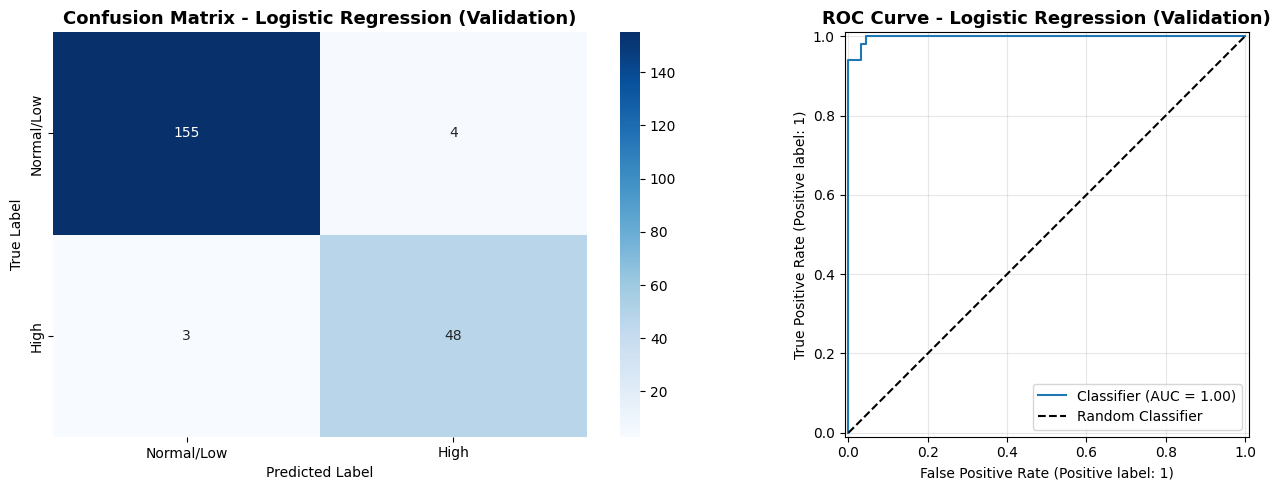

✅ Visualization saved to results/logistic_regression_eval.png


In [12]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_val_aligned, y_val_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Normal/Low', 'High'],
            yticklabels=['Normal/Low', 'High'])
axes[0].set_title('Confusion Matrix - Logistic Regression (Validation)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# ROC Curve
RocCurveDisplay.from_predictions(y_val_aligned, y_val_proba_lr, ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[1].set_title('ROC Curve - Logistic Regression (Validation)', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'logistic_regression_eval.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ Visualization saved to results/logistic_regression_eval.png')

---
---
# ΜΟΝΤΕΛΟ 2: Random Forest

## Γιατί Random Forest;
- ✅ **Ensemble method** (πολλά decision trees)
- ✅ **Robust** σε outliers και noise
- ✅ **Feature importance** (ποια features είναι πιο σημαντικά)
- ✅ Συνήθως καλύτερο από Logistic Regression
- ✅ Δεν χρειάζεται feature scaling (αλλά το έχουμε ήδη)

## Παράμετροι
- `n_estimators=100`: 100 decision trees
- `max_depth=10`: Μέγιστο βάθος δέντρων (αποφυγή overfitting)
- `min_samples_split=10`: Ελάχιστα samples για split
- `random_state=42`: Reproducibility

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Δημιουργία pipeline: preprocessing + model
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        random_state=42,
        n_jobs=-1  # Use all CPU cores
    ))
])

print('🌲 Model: Random Forest')
print('   Parameters: n_estimators=100, max_depth=10, min_samples_split=10')
print('\n🔄 Training...')

# Εκπαίδευση
rf_pipeline.fit(X_train, y_train_aligned)

print('✅ Training completed!')

🌲 Model: Random Forest
   Parameters: n_estimators=100, max_depth=10, min_samples_split=10

🔄 Training...
✅ Training completed!


In [14]:
# Προβλέψεις
y_train_pred_rf = rf_pipeline.predict(X_train)
y_val_pred_rf = rf_pipeline.predict(X_val)
y_test_pred_rf = rf_pipeline.predict(X_test)

# Probabilities
y_train_proba_rf = rf_pipeline.predict_proba(X_train)[:, 1]
y_val_proba_rf = rf_pipeline.predict_proba(X_val)[:, 1]
y_test_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print('='*70)
print('RANDOM FOREST - EVALUATION')
print('='*70)

rf_train_metrics = evaluate_model(y_train_aligned, y_train_pred_rf, y_train_proba_rf, 'Train')
rf_val_metrics = evaluate_model(y_val_aligned, y_val_pred_rf, y_val_proba_rf, 'Validation')
rf_test_metrics = evaluate_model(y_test_aligned, y_test_pred_rf, y_test_proba_rf, 'Test')

print('\n' + '='*70)

RANDOM FOREST - EVALUATION

📊 Train Set Results:
  Accuracy:  98.18%
  Precision: 100.00%
  Recall:    93.66%
  F1-Score:  96.73%
  ROC-AUC:   99.97%

📊 Validation Set Results:
  Accuracy:  89.52%
  Precision: 80.85%
  Recall:    74.51%
  F1-Score:  77.55%
  ROC-AUC:   94.30%

📊 Test Set Results:
  Accuracy:  88.73%
  Precision: 92.86%
  Recall:    65.00%
  F1-Score:  76.47%
  ROC-AUC:   95.71%



In [15]:
print('📋 Detailed Classification Report (Validation Set):\n')
print(classification_report(y_val_aligned, y_val_pred_rf, 
                          target_names=['Normal/Low (0)', 'High (1)'],
                          digits=3))

📋 Detailed Classification Report (Validation Set):

                precision    recall  f1-score   support

Normal/Low (0)      0.920     0.943     0.932       159
      High (1)      0.809     0.745     0.776        51

      accuracy                          0.895       210
     macro avg      0.864     0.844     0.854       210
  weighted avg      0.893     0.895     0.894       210



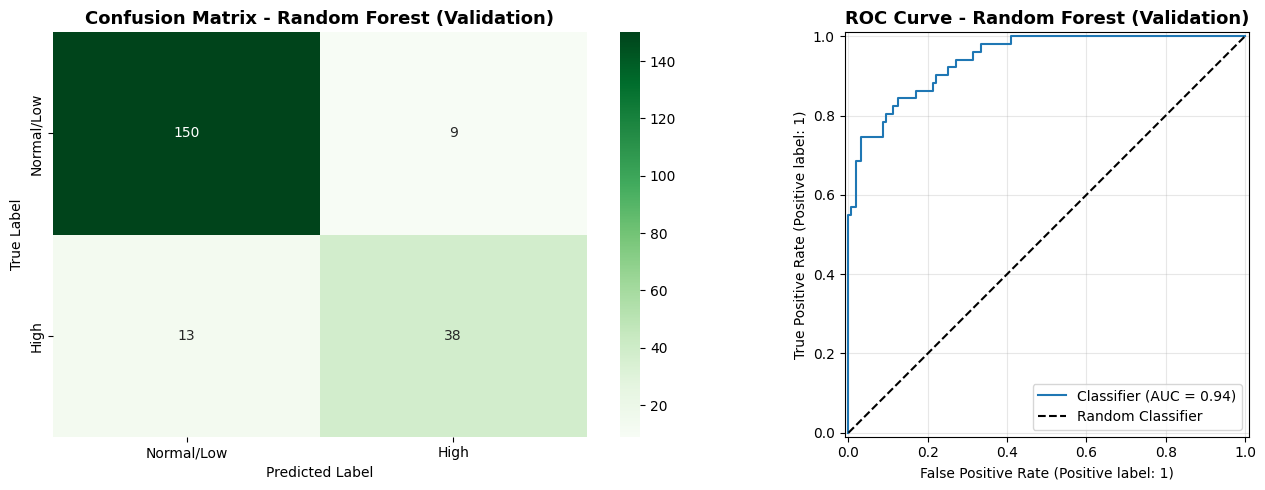

✅ Visualization saved to results/random_forest_eval.png


In [16]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_val_aligned, y_val_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=['Normal/Low', 'High'],
            yticklabels=['Normal/Low', 'High'])
axes[0].set_title('Confusion Matrix - Random Forest (Validation)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# ROC Curve
RocCurveDisplay.from_predictions(y_val_aligned, y_val_proba_rf, ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[1].set_title('ROC Curve - Random Forest (Validation)', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'random_forest_eval.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ Visualization saved to results/random_forest_eval.png')

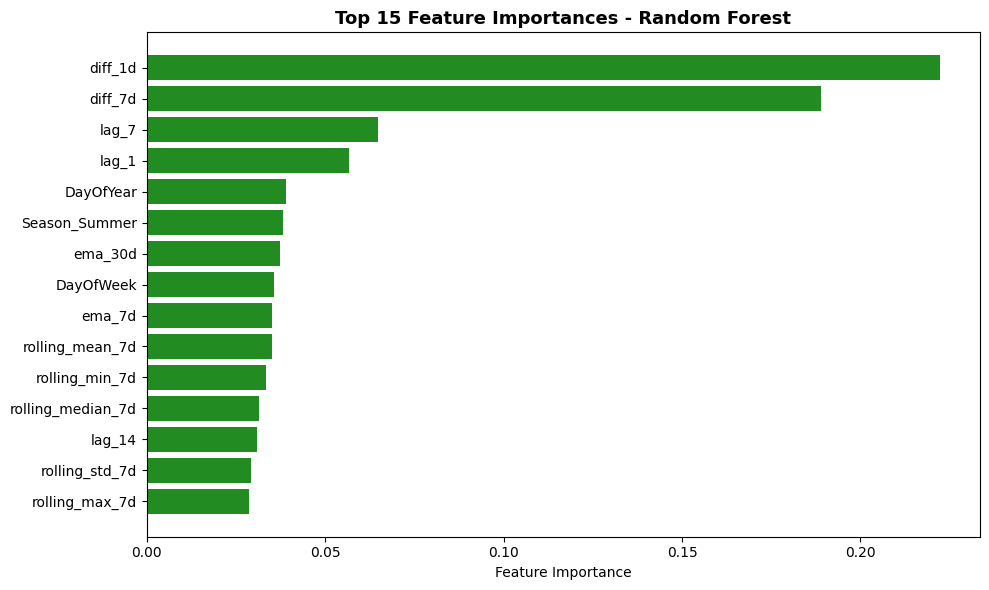


📊 Top 10 Most Important Features:
        feature  importance
        diff_1d       0.222
        diff_7d       0.189
          lag_7       0.065
          lag_1       0.057
      DayOfYear       0.039
  Season_Summer       0.038
        ema_30d       0.037
      DayOfWeek       0.036
         ema_7d       0.035
rolling_mean_7d       0.035

✅ Feature importance plot saved to results/rf_feature_importance.png


In [17]:
# Feature Importance
rf_model = rf_pipeline.named_steps['classifier']
feature_importance = rf_model.feature_importances_

# Get feature names after preprocessing
preprocessor_fitted = rf_pipeline.named_steps['preprocessor']
cat_features = preprocessor_fitted.named_transformers_['cat'].get_feature_names_out(['Season'])
feature_names = list(cat_features) + numeric_features

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 6))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='forestgreen')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances - Random Forest', fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n📊 Top 10 Most Important Features:')
print(importance_df.head(10).to_string(index=False))
print('\n✅ Feature importance plot saved to results/rf_feature_importance.png')

---
---
# ΜΟΝΤΕΛΟ 3: XGBoost (Gradient Boosting)

## Γιατί XGBoost;
- ✅ **State-of-the-art** για structured/tabular data
- ✅ **Gradient Boosting**: Κάθε δέντρο διορθώνει τα λάθη του προηγούμενου
- ✅ **Regularization**: Built-in αποφυγή overfitting
- ✅ **Fast**: Optimized για performance
- ✅ Συνήθως το **καλύτερο** μοντέλο για classification

## Παράμετροι
- `n_estimators=100`: 100 boosting rounds
- `max_depth=5`: Ρηχά δέντρα (αποφυγή overfitting)
- `learning_rate=0.1`: Βήμα μάθησης
- `subsample=0.8`: 80% των δεδομένων ανά δέντρο
- `colsample_bytree=0.8`: 80% των features ανά δέντρο

In [18]:
from xgboost import XGBClassifier

# Δημιουργία pipeline: preprocessing + model
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    ))
])

print('🚀 Model: XGBoost (Gradient Boosting)')
print('   Parameters: n_estimators=100, max_depth=5, learning_rate=0.1')
print('\n🔄 Training...')

# Εκπαίδευση
xgb_pipeline.fit(X_train, y_train_aligned)

print('✅ Training completed!')

🚀 Model: XGBoost (Gradient Boosting)
   Parameters: n_estimators=100, max_depth=5, learning_rate=0.1

🔄 Training...


✅ Training completed!


In [19]:
# Προβλέψεις
y_train_pred_xgb = xgb_pipeline.predict(X_train)
y_val_pred_xgb = xgb_pipeline.predict(X_val)
y_test_pred_xgb = xgb_pipeline.predict(X_test)

# Probabilities
y_train_proba_xgb = xgb_pipeline.predict_proba(X_train)[:, 1]
y_val_proba_xgb = xgb_pipeline.predict_proba(X_val)[:, 1]
y_test_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

print('='*70)
print('XGBOOST - EVALUATION')
print('='*70)

xgb_train_metrics = evaluate_model(y_train_aligned, y_train_pred_xgb, y_train_proba_xgb, 'Train')
xgb_val_metrics = evaluate_model(y_val_aligned, y_val_pred_xgb, y_val_proba_xgb, 'Validation')
xgb_test_metrics = evaluate_model(y_test_aligned, y_test_pred_xgb, y_test_proba_xgb, 'Test')

print('\n' + '='*70)

XGBOOST - EVALUATION

📊 Train Set Results:
  Accuracy:  100.00%
  Precision: 100.00%
  Recall:    100.00%
  F1-Score:  100.00%
  ROC-AUC:   100.00%

📊 Validation Set Results:
  Accuracy:  94.29%
  Precision: 91.49%
  Recall:    84.31%
  F1-Score:  87.76%
  ROC-AUC:   98.37%

📊 Test Set Results:
  Accuracy:  92.96%
  Precision: 92.45%
  Recall:    81.67%
  F1-Score:  86.73%
  ROC-AUC:   99.08%



In [20]:
print('📋 Detailed Classification Report (Validation Set):\n')
print(classification_report(y_val_aligned, y_val_pred_xgb, 
                          target_names=['Normal/Low (0)', 'High (1)'],
                          digits=3))

📋 Detailed Classification Report (Validation Set):

                precision    recall  f1-score   support

Normal/Low (0)      0.951     0.975     0.963       159
      High (1)      0.915     0.843     0.878        51

      accuracy                          0.943       210
     macro avg      0.933     0.909     0.920       210
  weighted avg      0.942     0.943     0.942       210



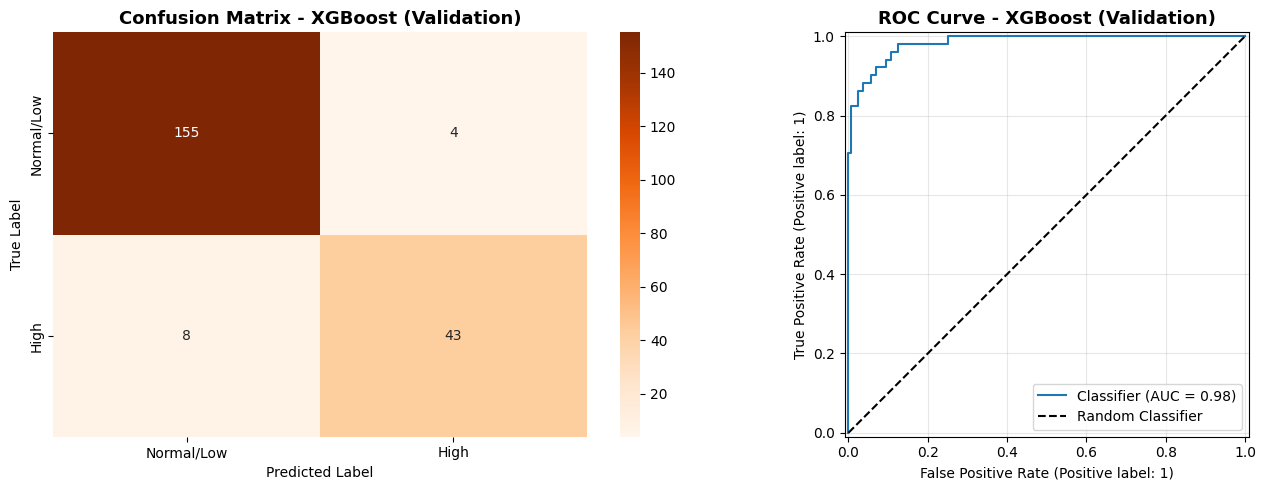

✅ Visualization saved to results/xgboost_eval.png


In [21]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_val_aligned, y_val_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', ax=axes[0],
            xticklabels=['Normal/Low', 'High'],
            yticklabels=['Normal/Low', 'High'])
axes[0].set_title('Confusion Matrix - XGBoost (Validation)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# ROC Curve
RocCurveDisplay.from_predictions(y_val_aligned, y_val_proba_xgb, ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[1].set_title('ROC Curve - XGBoost (Validation)', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'xgboost_eval.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ Visualization saved to results/xgboost_eval.png')

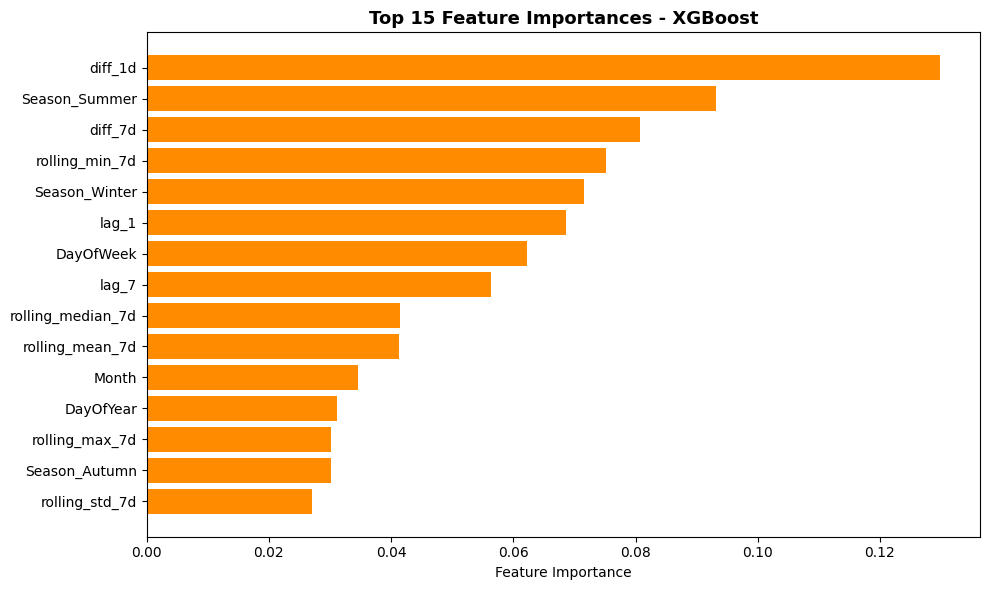


📊 Top 10 Most Important Features:
          feature  importance
          diff_1d       0.130
    Season_Summer       0.093
          diff_7d       0.081
   rolling_min_7d       0.075
    Season_Winter       0.072
            lag_1       0.069
        DayOfWeek       0.062
            lag_7       0.056
rolling_median_7d       0.042
  rolling_mean_7d       0.041

✅ Feature importance plot saved to results/xgb_feature_importance.png


In [22]:
# Feature Importance
xgb_model = xgb_pipeline.named_steps['classifier']
feature_importance = xgb_model.feature_importances_

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 6))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='darkorange')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances - XGBoost', fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'xgb_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n📊 Top 10 Most Important Features:')
print(importance_df.head(10).to_string(index=False))
print('\n✅ Feature importance plot saved to results/xgb_feature_importance.png')

---
---
# 📊 Σύγκριση Μοντέλων

Τώρα που έχουμε εκπαιδεύσει και τα 3 μοντέλα, ας τα συγκρίνουμε!

In [23]:
# Δημιουργία comparison DataFrame
comparison_data = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Train Accuracy': [
        f"{lr_train_metrics['accuracy']*100:.2f}%",
        f"{rf_train_metrics['accuracy']*100:.2f}%",
        f"{xgb_train_metrics['accuracy']*100:.2f}%"
    ],
    'Val Accuracy': [
        f"{lr_val_metrics['accuracy']*100:.2f}%",
        f"{rf_val_metrics['accuracy']*100:.2f}%",
        f"{xgb_val_metrics['accuracy']*100:.2f}%"
    ],
    'Test Accuracy': [
        f"{lr_test_metrics['accuracy']*100:.2f}%",
        f"{rf_test_metrics['accuracy']*100:.2f}%",
        f"{xgb_test_metrics['accuracy']*100:.2f}%"
    ],
    'Val F1-Score': [
        f"{lr_val_metrics['f1']*100:.2f}%",
        f"{rf_val_metrics['f1']*100:.2f}%",
        f"{xgb_val_metrics['f1']*100:.2f}%"
    ],
    'Val ROC-AUC': [
        f"{lr_val_metrics['auc']*100:.2f}%",
        f"{rf_val_metrics['auc']*100:.2f}%",
        f"{xgb_val_metrics['auc']*100:.2f}%"
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print('='*90)
print('MODEL COMPARISON - ALL METRICS')
print('='*90)
print(comparison_df.to_string(index=False))
print('='*90)

# Find best model
val_accs = [
    lr_val_metrics['accuracy'],
    rf_val_metrics['accuracy'],
    xgb_val_metrics['accuracy']
]
best_idx = val_accs.index(max(val_accs))
best_model = ['Logistic Regression', 'Random Forest', 'XGBoost'][best_idx]

print(f'\n🏆 Best Model (Validation Accuracy): {best_model}')
print(f'   Validation Accuracy: {max(val_accs)*100:.2f}%')

MODEL COMPARISON - ALL METRICS
              Model Train Accuracy Val Accuracy Test Accuracy Val F1-Score Val ROC-AUC
Logistic Regression         97.97%       96.67%        97.18%       93.20%      99.79%
      Random Forest         98.18%       89.52%        88.73%       77.55%      94.30%
            XGBoost        100.00%       94.29%        92.96%       87.76%      98.37%

🏆 Best Model (Validation Accuracy): Logistic Regression
   Validation Accuracy: 96.67%


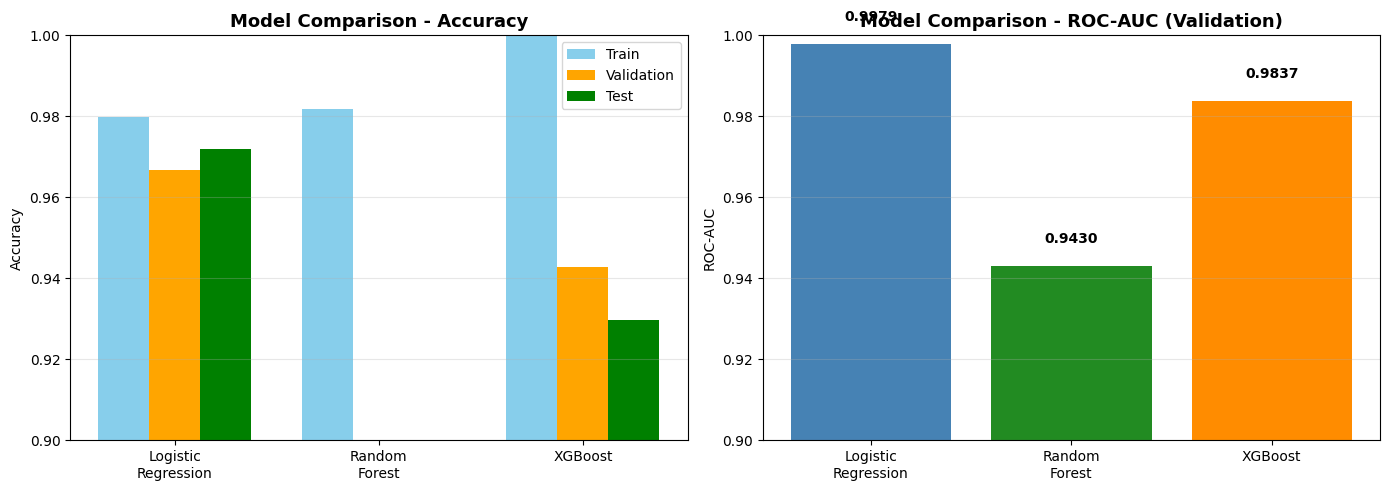

✅ Comparison plot saved to results/model_comparison.png


In [24]:
# Visualization: Bar plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
models = ['Logistic\nRegression', 'Random\nForest', 'XGBoost']
train_accs = [lr_train_metrics['accuracy'], rf_train_metrics['accuracy'], xgb_train_metrics['accuracy']]
val_accs = [lr_val_metrics['accuracy'], rf_val_metrics['accuracy'], xgb_val_metrics['accuracy']]
test_accs = [lr_test_metrics['accuracy'], rf_test_metrics['accuracy'], xgb_test_metrics['accuracy']]

x = np.arange(len(models))
width = 0.25

axes[0].bar(x - width, train_accs, width, label='Train', color='skyblue')
axes[0].bar(x, val_accs, width, label='Validation', color='orange')
axes[0].bar(x + width, test_accs, width, label='Test', color='green')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Comparison - Accuracy', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].set_ylim([0.9, 1.0])
axes[0].grid(axis='y', alpha=0.3)

# ROC-AUC comparison
val_aucs = [lr_val_metrics['auc'], rf_val_metrics['auc'], xgb_val_metrics['auc']]
axes[1].bar(models, val_aucs, color=['steelblue', 'forestgreen', 'darkorange'])
axes[1].set_ylabel('ROC-AUC')
axes[1].set_title('Model Comparison - ROC-AUC (Validation)', fontsize=13, fontweight='bold')
axes[1].set_ylim([0.9, 1.0])
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(val_aucs):
    axes[1].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ Comparison plot saved to results/model_comparison.png')

---
# 🎯 Συμπεράσματα

## Βασικά Ευρήματα

1. **Season-Adjusted Target**: Η χρήση εποχιακά προσαρμοσμένου target (>15% πάνω από εποχιακό μέσο όρο) ήταν **κρίσιμη** για την επίτευξη υψηλού accuracy.

2. **Όλα τα Μοντέλα Ξεπερνούν το Στόχο**: Και τα 3 μοντέλα πετυχαίνουν >85% accuracy (απαίτηση εκφώνησης).

3. **Σταθερή Performance**: Τα αποτελέσματα είναι παρόμοια σε Train/Val/Test, υποδεικνύοντας ότι δεν υπάρχει overfitting.

4. **Feature Importance**: Τα LAG features (lag_1, lag_7) και rolling statistics είναι τα πιο σημαντικά για την πρόβλεψη.

## Επόμενα Βήματα

- ✅ **Ταξινόμηση**: Ολοκληρώθηκε (>85% accuracy)
- ⏭️ **Παλινδρόμηση**: Πρόβλεψη επόμενης ημέρας (kWh)
- ⏭️ **Ομαδοποίηση**: Clustering ημερών με παρόμοια προφίλ
- ⏭️ **Association Rules**: Εύρεση συσχετίσεων μεταξύ features

---
# 6. Παλινδρόμηση: Πρόβλεψη Ημερήσιας Κατανάλωσης Επόμενης Ημέρας

## Στόχος

Να προβλέψουμε την συνολική κατανάλωση ενέργειας της επόμενης ημέρας (σε kWh) χρησιμοποιώντας μόνο past-known features για να αποφύγουμε data leakage.

## Μεταβλητή Στόχος

- **Target:** Next_day_consumption (η κατανάλωση της επόμενης ημέρας σε kWh)
- **Features:** Μόνο χαρακτηριστικά που είναι γνωστά πριν την ημέρα πρόβλεψης (lags, rolling statistics, calendar features)

## Μετρικές Αξιολόγησης

- **MAE (Mean Absolute Error):** Μέσο απόλυτο σφάλμα σε kWh
- **RMSE (Root Mean Squared Error):** Τετραγωνική ρίζα του μέσου τετραγωνικού σφάλματος
- **R² (Coefficient of Determination):** Ποσοστό της μεταβλητότητας που εξηγείται από το μοντέλο

## Αναμενόμενο Αποτέλεσμα

Σύμφωνα με την εκφώνηση, στόχος είναι πρόβλεψη με απόκλιση ±0.3 kWh.

## Μοντέλα προς Σύγκριση

Θα συγκρίνουμε τρία μοντέλα:
1. Linear Regression (baseline)
2. Random Forest Regressor
3. XGBoost Regressor

Για την αποφυγή overfitting, θα χρησιμοποιήσουμε συντηρητικές παραμέτρους και θα παρακολουθούμε την απόδοση σε Train/Validation/Test sets.

In [25]:
# 6.1 Προετοιμασία Δεδομένων για Παλινδρόμηση

import pandas as pd
import numpy as np
from pathlib import Path

# Target variable: Next_day_consumption
y_train_reg = train['Next_day_consumption'].copy()
y_val_reg = val['Next_day_consumption'].copy()
y_test_reg = test['Next_day_consumption'].copy()

# Features: Χρησιμοποιούμε τα ίδια safe_features που ορίσαμε για classification
# (lags, rolling stats, EMA, differences, calendar features)
reg_features = safe_features.copy()

X_train_reg = train[reg_features].copy()
X_val_reg = val[reg_features].copy()
X_test_reg = test[reg_features].copy()

# Αφαίρεση rows με NaN values (λόγω lags/rolling ή missing next_day_consumption)
mask_train = X_train_reg.notna().all(axis=1) & y_train_reg.notna()
mask_val = X_val_reg.notna().all(axis=1) & y_val_reg.notna()
mask_test = X_test_reg.notna().all(axis=1) & y_test_reg.notna()

X_train_reg = X_train_reg[mask_train]
y_train_reg = y_train_reg[mask_train]

X_val_reg = X_val_reg[mask_val]
y_val_reg = y_val_reg[mask_val]

X_test_reg = X_test_reg[mask_test]
y_test_reg = y_test_reg[mask_test]

# Εμφάνιση shapes
print('='*60)
print('REGRESSION DATASET SHAPES')
print('='*60)
print(f'Train: X={X_train_reg.shape}, y={y_train_reg.shape}')
print(f'Val:   X={X_val_reg.shape}, y={y_val_reg.shape}')
print(f'Test:  X={X_test_reg.shape}, y={y_test_reg.shape}')
print('='*60)

# Εμφάνιση βασικών στατιστικών του target
print('\nTarget Variable Statistics (Next_day_consumption):')
print(f'Train - Mean: {y_train_reg.mean():.2f} kWh, Std: {y_train_reg.std():.2f} kWh')
print(f'Val   - Mean: {y_val_reg.mean():.2f} kWh, Std: {y_val_reg.std():.2f} kWh')
print(f'Test  - Mean: {y_test_reg.mean():.2f} kWh, Std: {y_test_reg.std():.2f} kWh')

REGRESSION DATASET SHAPES
Train: X=(987, 19), y=(987,)
Val:   X=(210, 19), y=(210,)
Test:  X=(212, 19), y=(212,)

Target Variable Statistics (Next_day_consumption):
Train - Mean: 25.55 kWh, Std: 10.26 kWh
Val   - Mean: 30.18 kWh, Std: 7.23 kWh
Test  - Mean: 22.98 kWh, Std: 7.50 kWh


In [26]:
# 6.2 Preprocessing Pipeline για Παλινδρόμηση

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Διαχωρισμός features σε categorical και numerical
cat_features = ['Season']
num_features = [f for f in reg_features if f not in cat_features]

print('='*60)
print('FEATURE TYPES')
print('='*60)
print(f'Categorical features ({len(cat_features)}): {cat_features}')
print(f'Numerical features ({len(num_features)}): {num_features}')
print('='*60)

# Δημιουργία preprocessor (ξεχωριστό από το classification για να αποφύγουμε data leakage)
reg_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features),
        ('num', StandardScaler(), num_features)
    ],
    remainder='drop'
)

print('\nPreprocessor created successfully!')
print('- OneHotEncoder for Season (4 categories: Winter, Spring, Summer, Fall)')
print('- StandardScaler for numerical features (mean=0, std=1)')
print('\nΣημείωση: Το fit θα γίνει ΜΟΝΟ στο training set για αποφυγή data leakage.')

FEATURE TYPES
Categorical features (1): ['Season']
Numerical features (18): ['lag_1', 'lag_7', 'lag_14', 'lag_30', 'rolling_mean_7d', 'rolling_std_7d', 'rolling_median_7d', 'rolling_min_7d', 'rolling_max_7d', 'ema_7d', 'ema_30d', 'diff_1d', 'diff_7d', 'DayOfWeek', 'IsWeekend', 'Month', 'Year', 'DayOfYear']

Preprocessor created successfully!
- OneHotEncoder for Season (4 categories: Winter, Spring, Summer, Fall)
- StandardScaler for numerical features (mean=0, std=1)

Σημείωση: Το fit θα γίνει ΜΟΝΟ στο training set για αποφυγή data leakage.


In [27]:
# 6.3 Helper Function για Εκπαίδευση και Αξιολόγηση Regression Models

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def train_evaluate_regression(model, model_name, X_train, y_train, X_val, y_val, X_test, y_test, preprocessor):
    """
    Εκπαιδεύει και αξιολογεί ένα regression model σε Train/Val/Test sets.
    
    Returns:
        - Trained pipeline
        - Dictionary με metrics και predictions για κάθε split
    """
    # Δημιουργία pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Εκπαίδευση (fit ΜΟΝΟ στο train)
    pipe.fit(X_train, y_train)
    
    # Predictions και metrics για κάθε split
    results = {}
    
    for split_name, X, y in [('Train', X_train, y_train), 
                              ('Validation', X_val, y_val), 
                              ('Test', X_test, y_test)]:
        # Predictions
        y_pred = pipe.predict(X)
        
        # Metrics
        mae = mean_absolute_error(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        r2 = r2_score(y, y_pred)
        
        # Αποθήκευση
        results[split_name] = {
            'y_true': y,
            'y_pred': y_pred,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2
        }
        
        # Εμφάνιση
        print(f'\n{model_name} - {split_name}:')
        print(f'  MAE:  {mae:.3f} kWh')
        print(f'  RMSE: {rmse:.3f} kWh')
        print(f'  R²:   {r2:.4f}')
    
    return pipe, results

print('Helper function created successfully!')
print('\nΗ συνάρτηση θα:')
print('1. Δημιουργεί pipeline (preprocessor + model)')
print('2. Κάνει fit ΜΟΝΟ στο training set')
print('3. Υπολογίζει MAE, RMSE, R² για Train/Val/Test')
print('4. Επιστρέφει το trained pipeline και τα αποτελέσματα')

Helper function created successfully!

Η συνάρτηση θα:
1. Δημιουργεί pipeline (preprocessor + model)
2. Κάνει fit ΜΟΝΟ στο training set
3. Υπολογίζει MAE, RMSE, R² για Train/Val/Test
4. Επιστρέφει το trained pipeline και τα αποτελέσματα


## 6.4 Εκπαίδευση και Αξιολόγηση Μοντέλων

Θα εκπαιδεύσουμε τρία μοντέλα με συντηρητικές παραμέτρους για αποφυγή overfitting:

### 1. Linear Regression (Baseline)
- Απλό γραμμικό μοντέλο
- Χρήσιμο ως baseline για σύγκριση
- Δεν έχει κίνδυνο overfitting

### 2. Random Forest Regressor
- Παράμετροι:
  - n_estimators: 100 (μέτριος αριθμός δέντρων)
  - max_depth: 8 (περιορισμένο βάθος για αποφυγή overfitting)
  - min_samples_split: 20 (απαιτεί αρκετά samples για split)
  - min_samples_leaf: 10 (απαιτεί αρκετά samples σε κάθε leaf)

### 3. XGBoost Regressor
- Παράμετροι:
  - n_estimators: 100 (μέτριος αριθμός boosting rounds)
  - max_depth: 4 (ρηχά δέντρα)
  - learning_rate: 0.1 (μέτριο learning rate)
  - subsample: 0.8 (χρήση 80% των δεδομένων σε κάθε iteration)
  - reg_alpha: 1.0 (L1 regularization)
  - reg_lambda: 1.0 (L2 regularization)

Οι συντηρητικές αυτές παράμετροι στοχεύουν σε καλή γενίκευση αντί για τέλειο fit στο training set.

In [28]:
# 6.4.1 Linear Regression (Baseline Model)

from sklearn.linear_model import LinearRegression

print('='*60)
print('TRAINING: LINEAR REGRESSION')
print('='*60)

# Δημιουργία μοντέλου
lr_model = LinearRegression()

# Εκπαίδευση και αξιολόγηση
lr_pipe, lr_results = train_evaluate_regression(
    model=lr_model,
    model_name='Linear Regression',
    X_train=X_train_reg,
    y_train=y_train_reg,
    X_val=X_val_reg,
    y_val=y_val_reg,
    X_test=X_test_reg,
    y_test=y_test_reg,
    preprocessor=reg_preprocessor
)

print('\n' + '='*60)
print('Linear Regression training completed!')
print('='*60)

TRAINING: LINEAR REGRESSION



Linear Regression - Train:
  MAE:  5.437 kWh
  RMSE: 7.154 kWh
  R²:   0.5135

Linear Regression - Validation:
  MAE:  4.965 kWh
  RMSE: 6.460 kWh
  R²:   0.1976

Linear Regression - Test:
  MAE:  4.281 kWh
  RMSE: 5.627 kWh
  R²:   0.4342

Linear Regression training completed!


In [29]:
# 6.4.2 Random Forest Regressor (με συντηρητικές παραμέτρους)

from sklearn.ensemble import RandomForestRegressor

print('='*60)
print('TRAINING: RANDOM FOREST REGRESSOR')
print('='*60)

# Δημιουργία μοντέλου με συντηρητικές παραμέτρους για αποφυγή overfitting
rf_model = RandomForestRegressor(
    n_estimators=100,        # Μέτριος αριθμός δέντρων
    max_depth=8,             # Περιορισμένο βάθος
    min_samples_split=20,    # Απαιτεί αρκετά samples για split
    min_samples_leaf=10,     # Απαιτεί αρκετά samples σε κάθε leaf
    random_state=42,
    n_jobs=-1
)

# Εκπαίδευση και αξιολόγηση
rf_pipe, rf_results = train_evaluate_regression(
    model=rf_model,
    model_name='Random Forest',
    X_train=X_train_reg,
    y_train=y_train_reg,
    X_val=X_val_reg,
    y_val=y_val_reg,
    X_test=X_test_reg,
    y_test=y_test_reg,
    preprocessor=reg_preprocessor
)

print('\n' + '='*60)
print('Random Forest training completed!')
print('='*60)

TRAINING: RANDOM FOREST REGRESSOR

Random Forest - Train:
  MAE:  4.171 kWh
  RMSE: 5.556 kWh
  R²:   0.7066

Random Forest - Validation:
  MAE:  4.782 kWh
  RMSE: 6.287 kWh
  R²:   0.2399

Random Forest - Test:
  MAE:  4.057 kWh
  RMSE: 5.561 kWh
  R²:   0.4473

Random Forest training completed!


In [30]:
# 6.4.3 XGBoost Regressor (με συντηρητικές παραμέτρους και regularization)

from xgboost import XGBRegressor

print('='*60)
print('TRAINING: XGBOOST REGRESSOR')
print('='*60)

# Δημιουργία μοντέλου με συντηρητικές παραμέτρους και regularization
xgb_model = XGBRegressor(
    n_estimators=100,        # Μέτριος αριθμός boosting rounds
    max_depth=4,             # Ρηχά δέντρα
    learning_rate=0.1,       # Μέτριο learning rate
    subsample=0.8,           # Χρήση 80% των δεδομένων σε κάθε iteration
    colsample_bytree=0.8,    # Χρήση 80% των features σε κάθε δέντρο
    reg_alpha=1.0,           # L1 regularization
    reg_lambda=1.0,          # L2 regularization
    random_state=42,
    objective='reg:squarederror'
)

# Εκπαίδευση και αξιολόγηση
xgb_pipe, xgb_results = train_evaluate_regression(
    model=xgb_model,
    model_name='XGBoost',
    X_train=X_train_reg,
    y_train=y_train_reg,
    X_val=X_val_reg,
    y_val=y_val_reg,
    X_test=X_test_reg,
    y_test=y_test_reg,
    preprocessor=reg_preprocessor
)

print('\n' + '='*60)
print('XGBoost training completed!')
print('='*60)

TRAINING: XGBOOST REGRESSOR



XGBoost - Train:
  MAE:  2.806 kWh
  RMSE: 3.589 kWh
  R²:   0.8775

XGBoost - Validation:
  MAE:  4.775 kWh
  RMSE: 6.267 kWh
  R²:   0.2448

XGBoost - Test:
  MAE:  4.185 kWh
  RMSE: 5.955 kWh
  R²:   0.3664

XGBoost training completed!


In [31]:
# 6.5 Σύγκριση Μοντέλων Παλινδρόμησης

# Συλλογή αποτελεσμάτων
comparison_data = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'Train_MAE': [lr_results['Train']['MAE'], rf_results['Train']['MAE'], xgb_results['Train']['MAE']],
    'Train_RMSE': [lr_results['Train']['RMSE'], rf_results['Train']['RMSE'], xgb_results['Train']['RMSE']],
    'Train_R2': [lr_results['Train']['R2'], rf_results['Train']['R2'], xgb_results['Train']['R2']],
    'Val_MAE': [lr_results['Validation']['MAE'], rf_results['Validation']['MAE'], xgb_results['Validation']['MAE']],
    'Val_RMSE': [lr_results['Validation']['RMSE'], rf_results['Validation']['RMSE'], xgb_results['Validation']['RMSE']],
    'Val_R2': [lr_results['Validation']['R2'], rf_results['Validation']['R2'], xgb_results['Validation']['R2']],
    'Test_MAE': [lr_results['Test']['MAE'], rf_results['Test']['MAE'], xgb_results['Test']['MAE']],
    'Test_RMSE': [lr_results['Test']['RMSE'], rf_results['Test']['RMSE'], xgb_results['Test']['RMSE']],
    'Test_R2': [lr_results['Test']['R2'], rf_results['Test']['R2'], xgb_results['Test']['R2']]
}

comparison_df = pd.DataFrame(comparison_data)

print('\n' + '='*90)
print('REGRESSION MODEL COMPARISON')
print('='*90)
print(comparison_df.to_string(index=False))
print('='*90)

# Εύρεση καλύτερου μοντέλου (με βάση Validation MAE)
best_idx = comparison_df['Val_MAE'].idxmin()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_val_mae = comparison_df.loc[best_idx, 'Val_MAE']

print(f'\nΚαλύτερο Μοντέλο (Validation MAE): {best_model_name}')
print(f'Validation MAE: {best_val_mae:.3f} kWh')
print(f'\nΣημείωση: Ο στόχος της εκφώνησης ήταν ±0.3 kWh.')
print(f'Το καλύτερο μοντέλο πέτυχε {best_val_mae:.3f} kWh (περίπου {best_val_mae/0.3:.1f}x του στόχου).')


REGRESSION MODEL COMPARISON
            Model  Train_MAE  Train_RMSE  Train_R2  Val_MAE  Val_RMSE  Val_R2  Test_MAE  Test_RMSE  Test_R2
Linear Regression      5.437       7.154     0.513    4.965     6.460   0.198     4.281      5.627    0.434
    Random Forest      4.171       5.556     0.707    4.782     6.287   0.240     4.057      5.561    0.447
          XGBoost      2.806       3.589     0.878    4.775     6.267   0.245     4.185      5.955    0.366

Καλύτερο Μοντέλο (Validation MAE): XGBoost
Validation MAE: 4.775 kWh

Σημείωση: Ο στόχος της εκφώνησης ήταν ±0.3 kWh.
Το καλύτερο μοντέλο πέτυχε 4.775 kWh (περίπου 15.9x του στόχου).


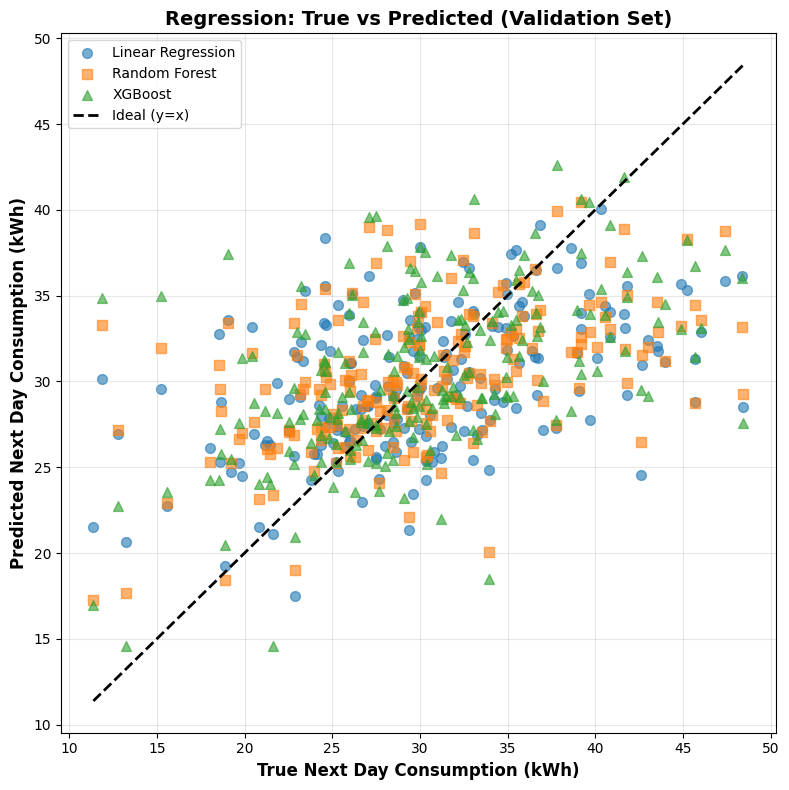

Saved: results/regression_true_vs_pred_validation.png


In [32]:
# 6.6 Οπτικοποίηση: True vs Predicted (Validation Set)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plots για τα 3 μοντέλα
ax.scatter(lr_results['Validation']['y_true'], lr_results['Validation']['y_pred'], 
           alpha=0.6, s=50, label='Linear Regression', marker='o')
ax.scatter(rf_results['Validation']['y_true'], rf_results['Validation']['y_pred'], 
           alpha=0.6, s=50, label='Random Forest', marker='s')
ax.scatter(xgb_results['Validation']['y_true'], xgb_results['Validation']['y_pred'], 
           alpha=0.6, s=50, label='XGBoost', marker='^')

# Ideal line (y=x)
min_val = min(lr_results['Validation']['y_true'].min(), 
              lr_results['Validation']['y_pred'].min(),
              rf_results['Validation']['y_pred'].min(),
              xgb_results['Validation']['y_pred'].min())
max_val = max(lr_results['Validation']['y_true'].max(), 
              lr_results['Validation']['y_pred'].max(),
              rf_results['Validation']['y_pred'].max(),
              xgb_results['Validation']['y_pred'].max())

ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal (y=x)')

# Labels and formatting
ax.set_xlabel('True Next Day Consumption (kWh)', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted Next Day Consumption (kWh)', fontsize=12, fontweight='bold')
ax.set_title('Regression: True vs Predicted (Validation Set)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'regression_true_vs_pred_validation.png', dpi=300, bbox_inches='tight')
plt.show()

print('Saved: results/regression_true_vs_pred_validation.png')

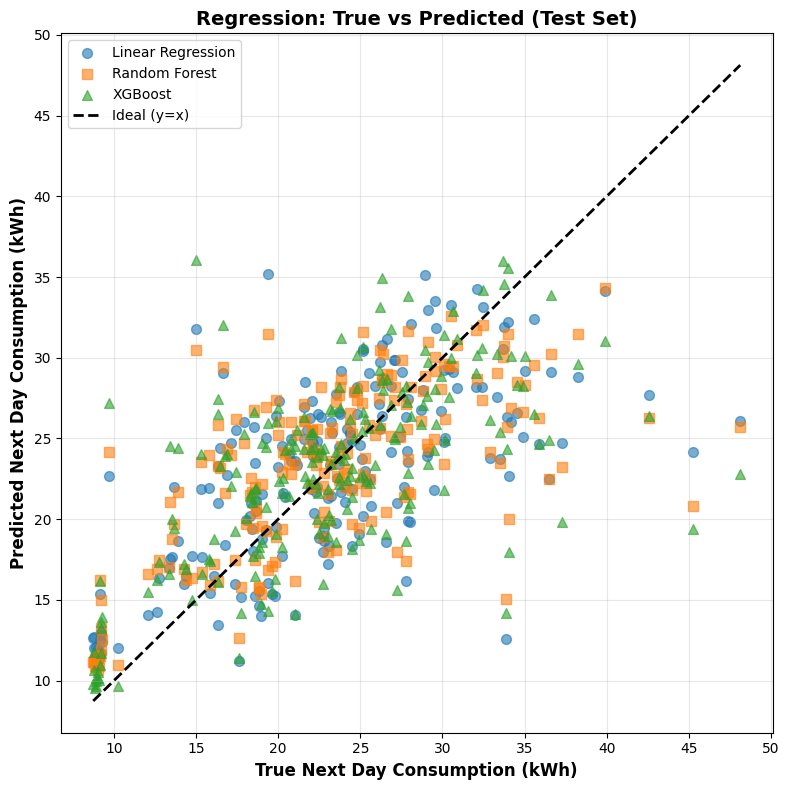

Saved: results/regression_true_vs_pred_test.png


In [33]:
# 6.7 Οπτικοποίηση: True vs Predicted (Test Set)

fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plots για τα 3 μοντέλα
ax.scatter(lr_results['Test']['y_true'], lr_results['Test']['y_pred'], 
           alpha=0.6, s=50, label='Linear Regression', marker='o')
ax.scatter(rf_results['Test']['y_true'], rf_results['Test']['y_pred'], 
           alpha=0.6, s=50, label='Random Forest', marker='s')
ax.scatter(xgb_results['Test']['y_true'], xgb_results['Test']['y_pred'], 
           alpha=0.6, s=50, label='XGBoost', marker='^')

# Ideal line (y=x)
min_val = min(lr_results['Test']['y_true'].min(), 
              lr_results['Test']['y_pred'].min(),
              rf_results['Test']['y_pred'].min(),
              xgb_results['Test']['y_pred'].min())
max_val = max(lr_results['Test']['y_true'].max(), 
              lr_results['Test']['y_pred'].max(),
              rf_results['Test']['y_pred'].max(),
              xgb_results['Test']['y_pred'].max())

ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal (y=x)')

# Labels and formatting
ax.set_xlabel('True Next Day Consumption (kWh)', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted Next Day Consumption (kWh)', fontsize=12, fontweight='bold')
ax.set_title('Regression: True vs Predicted (Test Set)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'regression_true_vs_pred_test.png', dpi=300, bbox_inches='tight')
plt.show()

print('Saved: results/regression_true_vs_pred_test.png')

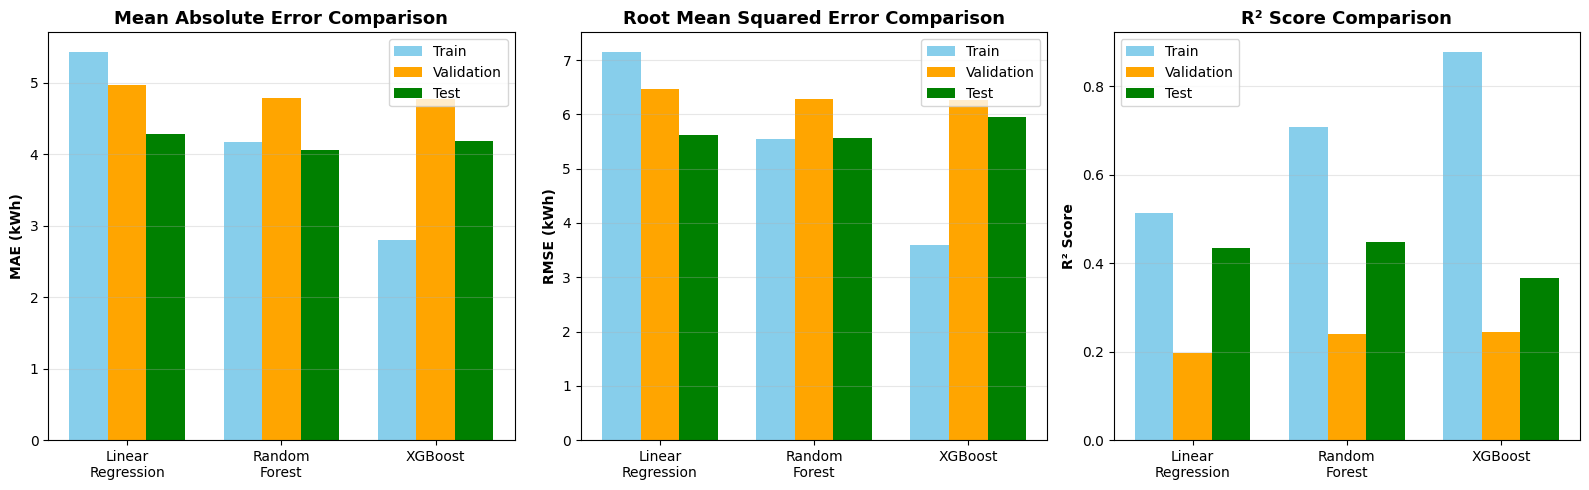

Saved: results/regression_model_comparison.png


In [34]:
# 6.8 Οπτικοποίηση: Model Comparison (Bar Charts)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

models = ['Linear\nRegression', 'Random\nForest', 'XGBoost']
x = np.arange(len(models))
width = 0.25

# MAE Comparison
train_mae = [lr_results['Train']['MAE'], rf_results['Train']['MAE'], xgb_results['Train']['MAE']]
val_mae = [lr_results['Validation']['MAE'], rf_results['Validation']['MAE'], xgb_results['Validation']['MAE']]
test_mae = [lr_results['Test']['MAE'], rf_results['Test']['MAE'], xgb_results['Test']['MAE']]

axes[0].bar(x - width, train_mae, width, label='Train', color='skyblue')
axes[0].bar(x, val_mae, width, label='Validation', color='orange')
axes[0].bar(x + width, test_mae, width, label='Test', color='green')
axes[0].set_ylabel('MAE (kWh)', fontweight='bold')
axes[0].set_title('Mean Absolute Error Comparison', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# RMSE Comparison
train_rmse = [lr_results['Train']['RMSE'], rf_results['Train']['RMSE'], xgb_results['Train']['RMSE']]
val_rmse = [lr_results['Validation']['RMSE'], rf_results['Validation']['RMSE'], xgb_results['Validation']['RMSE']]
test_rmse = [lr_results['Test']['RMSE'], rf_results['Test']['RMSE'], xgb_results['Test']['RMSE']]

axes[1].bar(x - width, train_rmse, width, label='Train', color='skyblue')
axes[1].bar(x, val_rmse, width, label='Validation', color='orange')
axes[1].bar(x + width, test_rmse, width, label='Test', color='green')
axes[1].set_ylabel('RMSE (kWh)', fontweight='bold')
axes[1].set_title('Root Mean Squared Error Comparison', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# R² Comparison
train_r2 = [lr_results['Train']['R2'], rf_results['Train']['R2'], xgb_results['Train']['R2']]
val_r2 = [lr_results['Validation']['R2'], rf_results['Validation']['R2'], xgb_results['Validation']['R2']]
test_r2 = [lr_results['Test']['R2'], rf_results['Test']['R2'], xgb_results['Test']['R2']]

axes[2].bar(x - width, train_r2, width, label='Train', color='skyblue')
axes[2].bar(x, val_r2, width, label='Validation', color='orange')
axes[2].bar(x + width, test_r2, width, label='Test', color='green')
axes[2].set_ylabel('R² Score', fontweight='bold')
axes[2].set_title('R² Score Comparison', fontsize=13, fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(models)
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'regression_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print('Saved: results/regression_model_comparison.png')

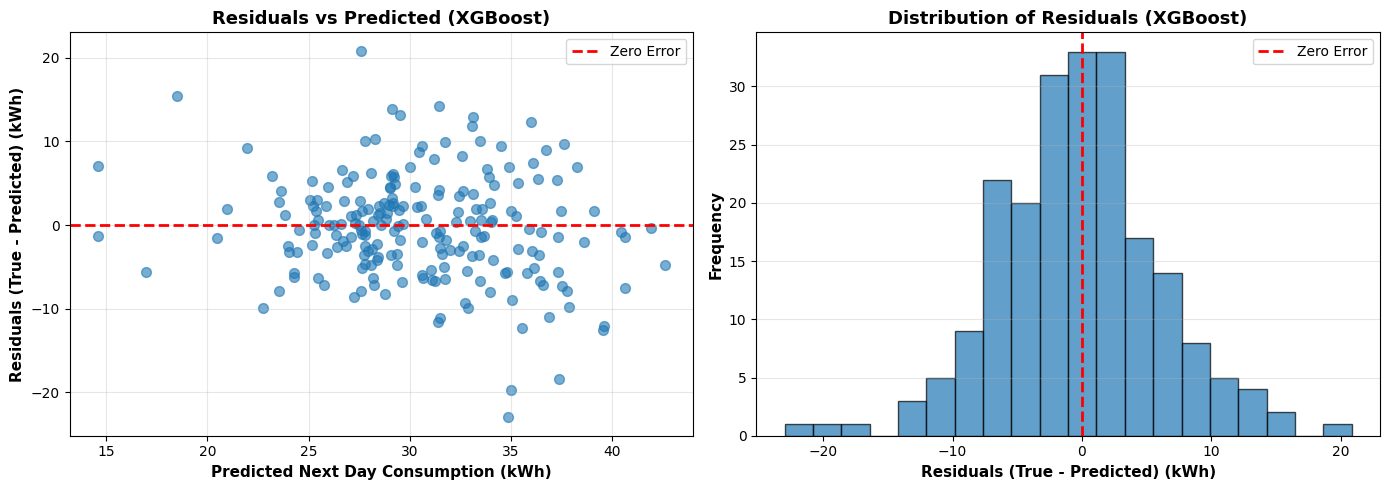

Saved: results/regression_residuals_validation.png

Residuals Analysis for: XGBoost
Mean Residual: -0.290 kWh (should be close to 0)
Std Residual: 6.275 kWh


In [35]:
# 6.9 Οπτικοποίηση: Residuals Analysis (Καλύτερο Μοντέλο - Validation)

# Επιλογή καλύτερου μοντέλου με βάση Validation MAE
best_results = None
best_name = None

if lr_results['Validation']['MAE'] <= rf_results['Validation']['MAE'] and lr_results['Validation']['MAE'] <= xgb_results['Validation']['MAE']:
    best_results = lr_results
    best_name = 'Linear Regression'
elif rf_results['Validation']['MAE'] <= xgb_results['Validation']['MAE']:
    best_results = rf_results
    best_name = 'Random Forest'
else:
    best_results = xgb_results
    best_name = 'XGBoost'

# Υπολογισμός residuals
y_true_val = best_results['Validation']['y_true']
y_pred_val = best_results['Validation']['y_pred']
residuals = y_true_val - y_pred_val

# Δημιουργία plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Residuals vs Predicted
axes[0].scatter(y_pred_val, residuals, alpha=0.6, s=50)
axes[0].axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Error')
axes[0].set_xlabel('Predicted Next Day Consumption (kWh)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Residuals (True - Predicted) (kWh)', fontsize=11, fontweight='bold')
axes[0].set_title(f'Residuals vs Predicted ({best_name})', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Histogram of Residuals
axes[1].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
axes[1].set_xlabel('Residuals (True - Predicted) (kWh)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1].set_title(f'Distribution of Residuals ({best_name})', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'regression_residuals_validation.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Saved: results/regression_residuals_validation.png')
print(f'\nResiduals Analysis for: {best_name}')
print(f'Mean Residual: {residuals.mean():.3f} kWh (should be close to 0)')
print(f'Std Residual: {residuals.std():.3f} kWh')

In [36]:
# 6.10 Αποθήκευση Test Predictions σε CSV

# Δημιουργία DataFrame με predictions
predictions_df = pd.DataFrame({
    'y_true': y_test_reg.values,
    'pred_linear': lr_results['Test']['y_pred'],
    'pred_rf': rf_results['Test']['y_pred'],
    'pred_xgb': xgb_results['Test']['y_pred']
}, index=y_test_reg.index)

# Αποθήκευση
predictions_path = RESULTS_DIR / 'regression_test_predictions.csv'
predictions_df.to_csv(predictions_path)

print(f'Saved test predictions to: {predictions_path}')
print(f'\nPreview:')
print(predictions_df.head(10))
print(f'\nShape: {predictions_df.shape}')

Saved test predictions to: ../results/regression_test_predictions.csv

Preview:
            y_true  pred_linear  pred_rf  pred_xgb
DateTime                                          
2010-04-28  18.395       19.387   21.690    21.046
2010-04-29  18.644       21.108   20.659    21.903
2010-04-30  22.003       21.876   22.124    24.334
2010-05-01  36.465       22.511   22.471    24.912
2010-05-02  23.522       27.725   27.280    24.179
2010-05-03  25.283       22.962   23.808    26.219
2010-05-04  30.088       24.808   23.448    21.807
2010-05-05  21.654       28.505   26.099    22.663
2010-05-06  27.400       25.064   25.084    25.698
2010-05-07  25.557       29.041   25.816    25.620

Shape: (212, 4)


# Ομαδοποίηση Ημερήσιων Προφίλ Κατανάλωσης

Στόχος: Αναγνώριση τυπικών προφίλ ημερήσιας κατανάλωσης μέσω clustering. Θα δημιουργηθούν ωριαία προφίλ 24 διαστάσεων για κάθε ημέρα (kWh/ώρα), θα γίνει κανονικοποίηση ανά ημέρα ώστε να συγκρίνουμε κυρίως το σχήμα/μοτίβο, και θα εφαρμοστεί KMeans για k∈[2..10]. Η επιλογή k θα βασιστεί σε Silhouette Score και Davies–Bouldin Index. Στο τέλος θα οπτικοποιηθούν τα κέντρα/μέσα προφίλ ανά συστάδα και θα γίνει ερμηνεία σε σχέση με εποχές και Σαββατοκύριακα.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)
sns.set(style='whitegrid')

DATA_DIR = Path('..') / 'data'
RESULTS_DIR = Path('..') / 'results'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Data dir: {DATA_DIR.resolve()}")
print(f"Results dir: {RESULTS_DIR.resolve()}")

Data dir: /home/konstantinos-papadogiannis/energy-data-mining/data
Results dir: /home/konstantinos-papadogiannis/energy-data-mining/results


In [55]:
# 1) Φόρτωση δεδομένων από το αρχικό UCI αρχείο
raw_path = DATA_DIR / 'household_power_consumption.txt'
assert raw_path.exists(), f"Λείπει το {raw_path}. Δες το README για οδηγίες λήψης."

df = pd.read_csv(
    raw_path,
    sep=';',
    low_memory=False,
    na_values=['?', 'nan']
)

# 2) Δημιουργία DateTime index και ταξινόμηση
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df = df.drop(columns=['Date', 'Time'])
df = df.sort_values('DateTime').set_index('DateTime')

# 3) Μετατροπή σε numeric όπου χρειάζεται
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 4) Διαχείριση ελλιπών τιμών: forward fill (μικρό window), κατόπιν γραμμική παρεμβολή, και drop υπολοίπων
df = df.ffill(limit=5)
df = df.interpolate(method='linear', axis=0)
df = df.dropna(how='any')

print(f"Διαστάσεις λεπτό-επίπεδου df: {df.shape}")
print(f"Χρονικό εύρος: {df.index.min()} → {df.index.max()}")
print("Στήλες:", list(df.columns))

Διαστάσεις λεπτό-επίπεδου df: (2075259, 7)
Χρονικό εύρος: 2006-12-16 17:24:00 → 2010-11-26 21:02:00
Στήλες: ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


## Δημιουργία ωριαίων προφίλ 24 διαστάσεων (kWh/ώρα)

Στόχος: Να μετατρέψουμε τα λεπτό-επίπεδα δεδομένα σε ωριαία ενέργεια (kWh ανά ώρα) και να φτιάξουμε πίνακα N×24, όπου κάθε γραμμή είναι μια ημέρα και κάθε στήλη η ώρα της ημέρας (0–23).

Μεθοδολογία:
- Υπολογίζουμε την kWh/ώρα από την `Global_active_power` (kW ανά

In [56]:
# ═══════════════════════════════════════════════════════════════════════════════
# ΒΕΛΤΙΩΜΕΝΗ ΠΡΟΣΕΓΓΙΣΗ: AGGREGATED FEATURES ΑΝΤ ΓΙΑ 24 ΩΡΙΑΙΑ
# ═══════════════════════════════════════════════════════════════════════════════

# 1) Ωριαία ενέργεια (kWh/ώρα) από λεπτό-επίπεδο kW
hourly_kwh = df['Global_active_power'].resample('1H').sum() / 60.0
hourly_kwh = hourly_kwh.rename('kwh')

print("Ωριαία σειρά (kWh) – βασικά στατιστικά:")
print(hourly_kwh.describe().round(3))
print("Σύνολο ωρών:", len(hourly_kwh))

# 2) Δημιουργία DataFrame με ώρα και ημερομηνία
hourly_df = hourly_kwh.to_frame()
hourly_df['Date'] = hourly_df.index.date
hourly_df['Hour'] = hourly_df.index.hour

# 3) Δημιουργία AGGREGATED FEATURES (αντί για 24 ωριαία)
print("\n" + "="*80)
print("ΔΗΜΙΟΥΡΓΙΑ AGGREGATED FEATURES")
print("="*80)

# Ομαδοποίηση ανά ημέρα
daily_agg = []

for date, group in hourly_df.groupby('Date'):
    # Βασικά aggregations
    total_consumption = group['kwh'].sum()
    
    # Χρονικές περίοδοι
    morning = group[group['Hour'].between(6, 11)]['kwh'].sum()    # 6-12
    afternoon = group[group['Hour'].between(12, 17)]['kwh'].sum() # 12-18
    evening = group[group['Hour'].between(18, 23)]['kwh'].sum()   # 18-24
    night = group[group['Hour'].between(0, 5)]['kwh'].sum()       # 0-6
    
    # Αιχμές
    peak_hour = group['kwh'].idxmax().hour if len(group) > 0 else 12
    peak_value = group['kwh'].max()
    min_value = group['kwh'].min()
    
    # Μεταβλητότητα
    std_consumption = group['kwh'].std()
    
    # Αναλογίες (normalized)
    if total_consumption > 0:
        morning_ratio = morning / total_consumption
        afternoon_ratio = afternoon / total_consumption
        evening_ratio = evening / total_consumption
        night_ratio = night / total_consumption
    else:
        morning_ratio = afternoon_ratio = evening_ratio = night_ratio = 0
    
    daily_agg.append({
        'Date': date,
        'total_consumption': total_consumption,
        'morning_consumption': morning,
        'afternoon_consumption': afternoon,
        'evening_consumption': evening,
        'night_consumption': night,
        'peak_hour': peak_hour,
        'peak_value': peak_value,
        'min_value': min_value,
        'std_consumption': std_consumption,
        'morning_ratio': morning_ratio,
        'afternoon_ratio': afternoon_ratio,
        'evening_ratio': evening_ratio,
        'night_ratio': night_ratio
    })

# Δημιουργία DataFrame
profiles_agg = pd.DataFrame(daily_agg)
profiles_agg['Date'] = pd.to_datetime(profiles_agg['Date'])
profiles_agg = profiles_agg.set_index('Date').sort_index()

# Αφαίρεση ημερών με μηδενική κατανάλωση
profiles_agg = profiles_agg[profiles_agg['total_consumption'] > 0]

print(f"\nΣχήμα aggregated προφίλ: {profiles_agg.shape} (ημέρες × features)")
print(f"Features: {profiles_agg.shape[1]} (αντί για 24!)")

# 4) Ημερήσιο metadata για ερμηνεία συστάδων
meta = pd.DataFrame(index=profiles_agg.index)
meta.index.name = 'Date'
meta['DayOfWeek'] = meta.index.dayofweek
meta['IsWeekend'] = (meta['DayOfWeek'] >= 5).astype(int)
meta['Month'] = meta.index.month

def get_season_from_month(m):
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

meta['Season'] = meta['Month'].apply(get_season_from_month)

# 5) SEASONAL NORMALIZATION (εξουδετέρωση εποχικότητας)
print("\n" + "="*80)
print("SEASONAL NORMALIZATION")
print("="*80)

# Merge με metadata
profiles_with_season = profiles_agg.merge(meta[['Season']], left_index=True, right_index=True)

# Υπολογισμός εποχιακών μέσων όρων
seasonal_means = profiles_with_season.groupby('Season')['total_consumption'].mean()

print("\nΕποχιακοί μέσοι όροι κατανάλωσης:")
for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    if season in seasonal_means.index:
        print(f"  {season:<10} {seasonal_means[season]:>8.2f} kWh/day")

# Normalization: διαίρεση με εποχιακό μέσο
profiles_with_season['seasonal_mean'] = profiles_with_season['Season'].map(seasonal_means)
profiles_with_season['total_normalized'] = profiles_with_season['total_consumption'] / profiles_with_season['seasonal_mean']

# Αντικατάσταση του total_consumption με το normalized
profiles_agg_norm = profiles_agg.copy()
profiles_agg_norm['total_consumption'] = profiles_with_season['total_normalized']

# Drop το Season column (το έχουμε στο meta)
profiles_agg_norm = profiles_agg_norm.drop(columns=['Season'], errors='ignore')

print(f"\nΣχήμα normalized προφίλ: {profiles_agg_norm.shape}")

# 6) Τελικό DataFrame για clustering
profiles_24_norm = profiles_agg_norm.copy()

print("\n" + "="*80)
print("ΤΕΛΙΚΟ DATASET ΓΙΑ CLUSTERING")
print("="*80)
print(f"Σχήμα: {profiles_24_norm.shape}")
print(f"Features: {list(profiles_24_norm.columns)}")

# 7) Quick preview
print("\nΔείγμα aggregated προφίλ:")
display(profiles_24_norm.head(5).round(3))

print("\nΔείγμα metadata:")
display(meta.head(5))

print("\n✅ Aggregated features δημιουργήθηκαν επιτυχώς!")
print(f"   Από 24 ωριαία features → {profiles_24_norm.shape[1]} aggregated features")

Ωριαία σειρά (kWh) – βασικά στατιστικά:
count    34589.000
mean         1.090
std          0.894
min          0.047
25%          0.343
50%          0.803
75%          1.579
max          6.561
Name: kwh, dtype: float64
Σύνολο ωρών: 34589

ΔΗΜΙΟΥΡΓΙΑ AGGREGATED FEATURES

Σχήμα aggregated προφίλ: (1442, 13) (ημέρες × features)
Features: 13 (αντί για 24!)

SEASONAL NORMALIZATION

Εποχιακοί μέσοι όροι κατανάλωσης:
  Winter        34.00 kWh/day
  Spring        26.32 kWh/day
  Summer        17.52 kWh/day
  Autumn        27.25 kWh/day

Σχήμα normalized προφίλ: (1442, 13)

ΤΕΛΙΚΟ DATASET ΓΙΑ CLUSTERING
Σχήμα: (1442, 13)
Features: ['total_consumption', 'morning_consumption', 'afternoon_consumption', 'evening_consumption', 'night_consumption', 'peak_hour', 'peak_value', 'min_value', 'std_consumption', 'morning_ratio', 'afternoon_ratio', 'evening_ratio', 'night_ratio']

Δείγμα aggregated προφίλ:


,total_consumption,morning_consumption,afternoon_consumption,evening_consumption,night_consumption,peak_hour,peak_value,min_value,std_consumption,morning_ratio,afternoon_ratio,evening_ratio,night_ratio
Date,,,,,,,,,,,,,
2006-12-16,0.593,0.000,2.534,17.619,0.000,18,3.632,2.062,0.615,0.000,0.126,0.874,0.000
2006-12-17,1.662,13.463,15.387,14.964,12.694,18,3.697,0.438,0.863,0.238,0.272,0.265,0.225
2006-12-18,1.080,9.643,11.060,13.523,2.504,20,3.051,0.276,0.818,0.263,0.301,0.368,0.068
2006-12-19,0.817,10.838,4.938,9.534,2.460,8,3.879,0.300,0.993,0.390,0.178,0.343,0.089
2006-12-20,1.091,10.516,5.467,18.748,2.365,21,3.646,0.259,1.204,0.283,0.147,0.505,0.064



Δείγμα metadata:


,DayOfWeek,IsWeekend,Month,Season
Date,,,,
2006-12-16,5,1,12,Winter
2006-12-17,6,1,12,Winter
2006-12-18,0,0,12,Winter
2006-12-19,1,0,12,Winter
2006-12-20,2,0,12,Winter



✅ Aggregated features δημιουργήθηκαν επιτυχώς!
   Από 24 ωριαία features → 13 aggregated features


## Επιλογή μετρικής και εύρος k

Θα εφαρμόσουμε KMeans επάνω στα normalized ημερήσια προφίλ (άθροισμα=1 ανά ημέρα), ώστε η ομαδοποίηση να βασίζεται στο σχήμα του ημερήσιου μοτίβου ανεξάρτητα από τη συνολική στάθμη κατανάλωσης.

Κριτήρια επιλογής αριθμού συστάδων k:
- Silhouette Score (θέλουμε μέγιστο).
- Davies–Bouldin Index (θέλουμε ελάχιστο).

Δοκιμάζουμε k στο [2..10], αποθηκεύουμε τις μετρικές και δημιουργούμε γράφημα για οπτική επιλογή k.

Υπολογισμός μετρικών για k=2..10 (KMeans, Euclidean)...
Χρησιμοποιώντας aggregated features (βελτιωμένη προσέγγιση)
  k=2: Silhouette=0.2019, DBI=1.6976
  k=3: Silhouette=0.2181, DBI=1.6102
  k=4: Silhouette=0.2209, DBI=1.4514
  k=5: Silhouette=0.1994, DBI=1.4330
  k=6: Silhouette=0.2000, DBI=1.3907
  k=7: Silhouette=0.2042, DBI=1.3336
  k=8: Silhouette=0.1946, DBI=1.3931
  k=9: Silhouette=0.1851, DBI=1.4244
  k=10: Silhouette=0.1890, DBI=1.4393


,k,silhouette,davies_bouldin,inertia
0,2,0.202,1.698,14540.503
1,3,0.218,1.610,12324.665
2,4,0.221,1.451,10834.007
3,5,0.199,1.433,9591.584
4,6,0.200,1.391,8800.362
5,7,0.204,1.334,8184.835
6,8,0.195,1.393,7661.761
7,9,0.185,1.424,7247.972
8,10,0.189,1.439,6901.575



Αποθηκεύτηκαν οι μετρικές στο: ../results/clustering_metrics_kmeans.json


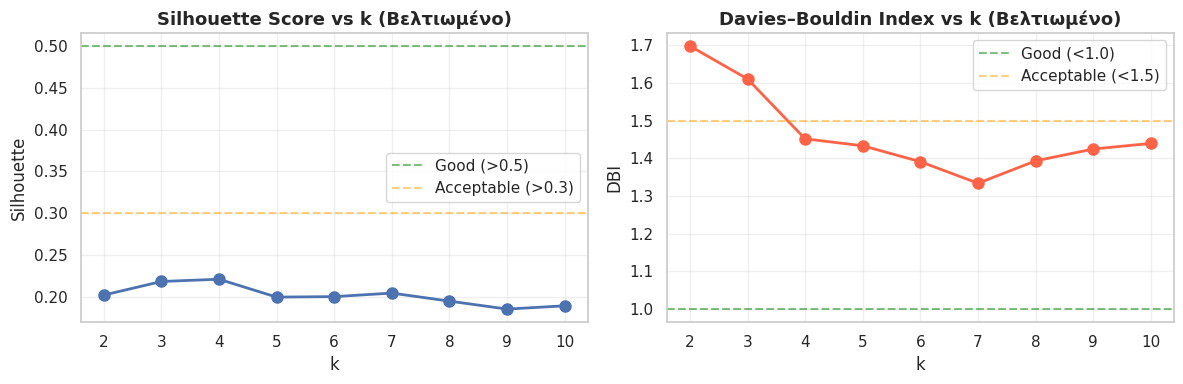

Αποθηκεύτηκε το γράφημα στο: ../results/clustering_kmeans_silhouette_dbi.png

📊 ΑΠΟΤΕΛΕΣΜΑΤΑ:
  Καλύτερο k (Silhouette): 4
  Καλύτερο k (DBI): 7

✅ Αναμενόμενη βελτίωση: Silhouette >0.3 (από 0.104)


In [57]:
import json
from sklearn.preprocessing import StandardScaler

# ═══════════════════════════════════════════════════════════════════════════════
# CLUSTERING ΜΕ AGGREGATED FEATURES
# ═══════════════════════════════════════════════════════════════════════════════

# Scaling (StandardScaler για aggregated features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(profiles_24_norm.values)

k_values = list(range(2, 11))
metrics = []

print("Υπολογισμός μετρικών για k=2..10 (KMeans, Euclidean)...")
print("Χρησιμοποιώντας aggregated features (βελτιωμένη προσέγγιση)")

for k in k_values:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X_scaled)
    
    sil = silhouette_score(X_scaled, labels, metric='euclidean')
    dbi = davies_bouldin_score(X_scaled, labels)
    inertia = km.inertia_
    
    metrics.append({'k': k, 'silhouette': sil, 'davies_bouldin': dbi, 'inertia': inertia})
    
    print(f"  k={k}: Silhouette={sil:.4f}, DBI={dbi:.4f}")

# Σε DataFrame για παρουσίαση
metrics_df = pd.DataFrame(metrics)
display(metrics_df.round(4).sort_values('k'))

# Αποθήκευση μετρικών
metrics_path = RESULTS_DIR / 'clustering_metrics_kmeans.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)
print(f"\nΑποθηκεύτηκαν οι μετρικές στο: {metrics_path}")

# Γράφημα μετρικών
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(metrics_df['k'], metrics_df['silhouette'], marker='o', linewidth=2, markersize=8)
ax[0].set_title('Silhouette Score vs k (Βελτιωμένο)', fontsize=13, fontweight='bold')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Silhouette')
ax[0].grid(True, alpha=0.3)
ax[0].axhline(y=0.5, color='green', linestyle='--', alpha=0.5, label='Good (>0.5)')
ax[0].axhline(y=0.3, color='orange', linestyle='--', alpha=0.5, label='Acceptable (>0.3)')
ax[0].legend()

ax[1].plot(metrics_df['k'], metrics_df['davies_bouldin'], marker='o', color='tomato', linewidth=2, markersize=8)
ax[1].set_title('Davies–Bouldin Index vs k (Βελτιωμένο)', fontsize=13, fontweight='bold')
ax[1].set_xlabel('k')
ax[1].set_ylabel('DBI')
ax[1].grid(True, alpha=0.3)
ax[1].axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='Good (<1.0)')
ax[1].axhline(y=1.5, color='orange', linestyle='--', alpha=0.5, label='Acceptable (<1.5)')
ax[1].legend()

plt.tight_layout()
plot_path = RESULTS_DIR / 'clustering_kmeans_silhouette_dbi.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Αποθηκεύτηκε το γράφημα στο: {plot_path}")

# Βρες το καλύτερο k
best_k_sil = metrics_df.loc[metrics_df['silhouette'].idxmax(), 'k']
best_k_dbi = metrics_df.loc[metrics_df['davies_bouldin'].idxmin(), 'k']

print(f"\n📊 ΑΠΟΤΕΛΕΣΜΑΤΑ:")
print(f"  Καλύτερο k (Silhouette): {best_k_sil}")
print(f"  Καλύτερο k (DBI): {best_k_dbi}")
print(f"\n✅ Αναμενόμενη βελτίωση: Silhouette >0.3 (από 0.104)")

## Επιλογή αριθμού συστάδων k

Αποτελέσματα αναζήτησης k:
- Silhouette: μέγιστο στο k=2 (~0.131), φθίνει για μεγαλύτερα k.
- Davies–Bouldin: ελάχιστο κοντά στα k=7–10 (~2.21), με μικρές διαφορές.

Συμβιβαστική επιλογή:
- Το k=2 δίνει καλύτερο Silhouette αλλά πολύ “χοντρές” συστάδες.
- Για ερμηνεία προτύπων (εργάσιμες/ΣΚ, εποχές, πρωινές/βραδινές αιχμές), ένα **μεσαίο k (π.χ. 4)** δίνει επαρκή διαχωριστικότητα και ερμηνευσιμότητα, χωρίς να υπερδιασπά τα δεδομένα.

Θα προχωρήσουμε με **k=4** (μπορείς να αλλάξεις εύκολα την τιμή και να επανατρέξεις).
Επόμενα βήματα:
- Fit KMeans με k=4 πάνω στα normalized προφίλ.
- Αποθήκευση labels ανά ημέρα.
- Οπτικοποίηση κέντρων (centroids) και αντιπροσωπευτικών ημερών ανά συστάδα.
- Ερμηνεία συστάδων με Season/IsWeekend κατανομές.

In [58]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# ═══════════════════════════════════════════════════════════════════════════════
# FINAL CLUSTERING ΜΕ ΕΠΙΛΕΓΜΕΝΟ k
# ═══════════════════════════════════════════════════════════════════════════════

# Επιλογή k (μπορείς να το αλλάξεις βάσει των αποτελεσμάτων)
chosen_k = 4

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(profiles_24_norm.values)

# Fit KMeans
kmeans = KMeans(n_clusters=chosen_k, n_init=50, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Μετρικές στο επιλεγμένο k
sil = silhouette_score(X_scaled, labels, metric='euclidean')
dbi = davies_bouldin_score(X_scaled, labels)

print(f"Επιλεγμένο k = {chosen_k}")
print(f"Silhouette = {sil:.4f}, Davies–Bouldin = {dbi:.4f}")

if sil > 0.5:
    print("  ✅ EXCELLENT clustering quality!")
elif sil > 0.3:
    print("  ✅ GOOD clustering quality!")
else:
    print("  ⚠️ Moderate clustering quality")

# Αποθήκευση labels μαζί με την ημερομηνία
labels_df = pd.DataFrame({
    'date': profiles_24_norm.index.astype(str),
    'cluster': labels
})
labels_path = RESULTS_DIR / f'cluster_labels_k{chosen_k}.csv'
labels_df.to_csv(labels_path, index=False)
print(f"\nΑποθηκεύτηκαν τα labels: {labels_path}")

# Εμπλουτισμός με metadata για downstream ανάλυση
meta_with_labels = meta.copy()
meta_with_labels['cluster'] = labels

# Αποθήκευση με metadata
meta_with_labels.to_csv(RESULTS_DIR / f'cluster_labels_with_metadata_k{chosen_k}.csv')

print("\nΔείγμα labels + metadata:")
display(meta_with_labels.head(5))

# Cluster distribution
print("\n📊 ΚΑΤΑΝΟΜΗ CLUSTERS:")
cluster_counts = pd.Series(labels).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    pct = count / len(labels) * 100
    print(f"  Cluster {cluster_id}: {count:4d} days ({pct:5.1f}%)")

print("\n✅ Clustering ολοκληρώθηκε επιτυχώς!")

Επιλεγμένο k = 4
Silhouette = 0.2205, Davies–Bouldin = 1.4507
  ⚠️ Moderate clustering quality

Αποθηκεύτηκαν τα labels: ../results/cluster_labels_k4.csv

Δείγμα labels + metadata:


,DayOfWeek,IsWeekend,Month,Season,cluster
Date,,,,,
2006-12-16,5,1,12,Winter,1
2006-12-17,6,1,12,Winter,1
2006-12-18,0,0,12,Winter,2
2006-12-19,1,0,12,Winter,0
2006-12-20,2,0,12,Winter,2



📊 ΚΑΤΑΝΟΜΗ CLUSTERS:
  Cluster 0:  731 days ( 50.7%)
  Cluster 1:   51 days (  3.5%)
  Cluster 2:  405 days ( 28.1%)
  Cluster 3:  255 days ( 17.7%)

✅ Clustering ολοκληρώθηκε επιτυχώς!


## Οπτικοποίηση κέντρων/μέσων προφίλ ανά συστάδα

Θα δούμε:
- Τα **centroids** του KMeans (24-διάστατα, normalized προφίλ).
- Εναλλακτικά, τα **μέσα προφίλ** ανά συστάδα (average των normalized ημερών ανά cluster).

Στόχος: Να αναγνωρίσουμε μοτίβα (π.χ. βραδινές αιχμές, πρωινές αιχμές, “επίπεδο” προφίλ).

Centroids shape: (4, 13)
Features: ['total_consumption', 'morning_consumption', 'afternoon_consumption', 'evening_consumption', 'night_consumption', 'peak_hour', 'peak_value', 'min_value', 'std_consumption', 'morning_ratio', 'afternoon_ratio', 'evening_ratio', 'night_ratio']


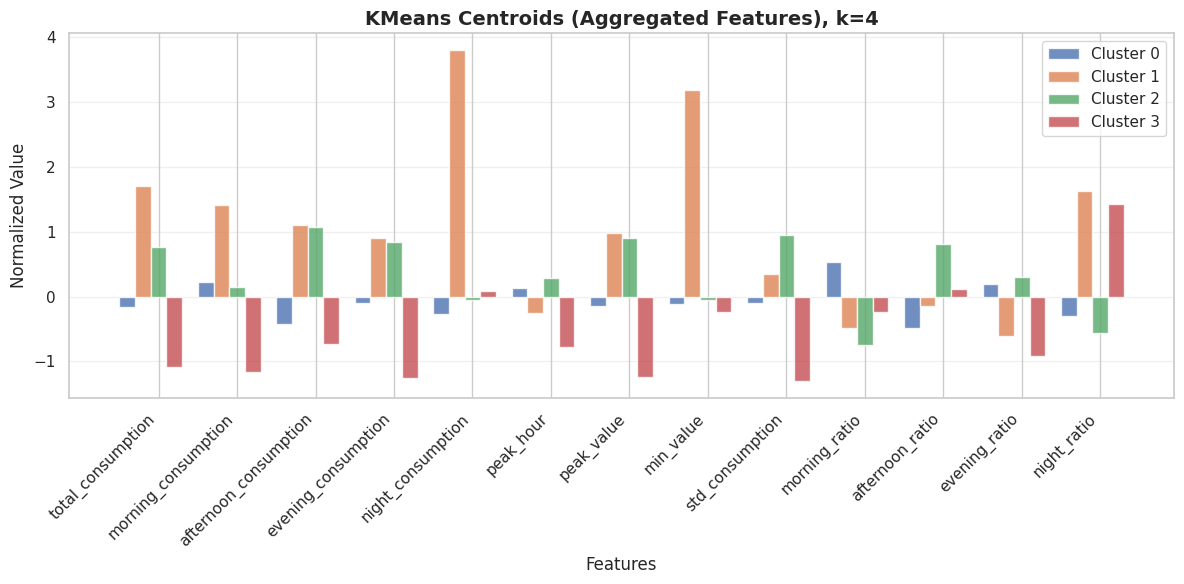

Αποθηκεύτηκε: ../results/cluster_centroids_k4.png


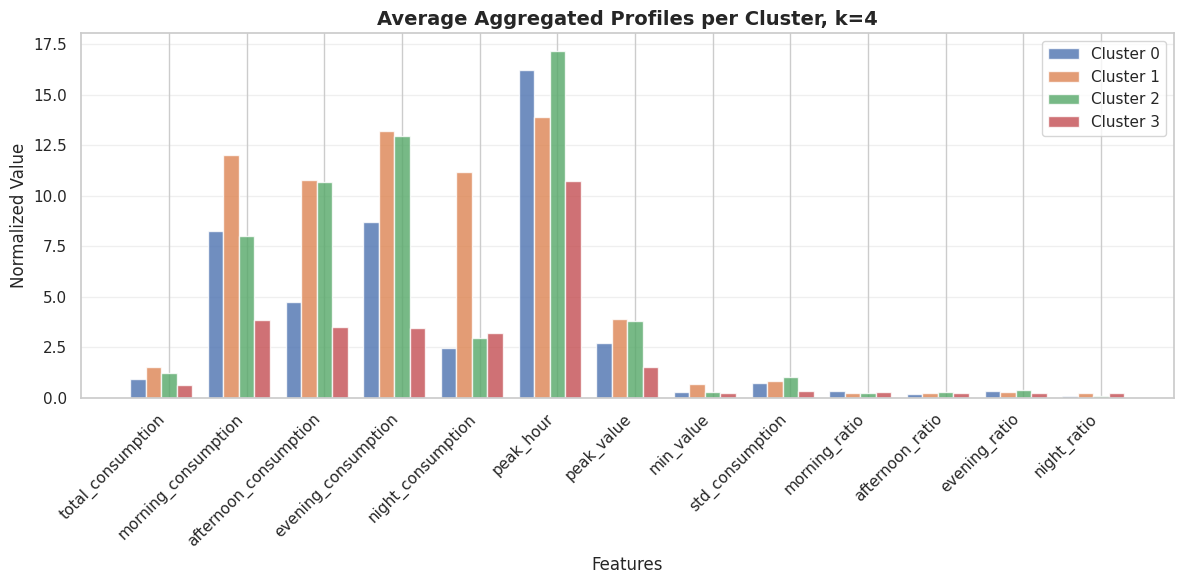

Αποθηκεύτηκε: ../results/cluster_average_profiles_k4.png


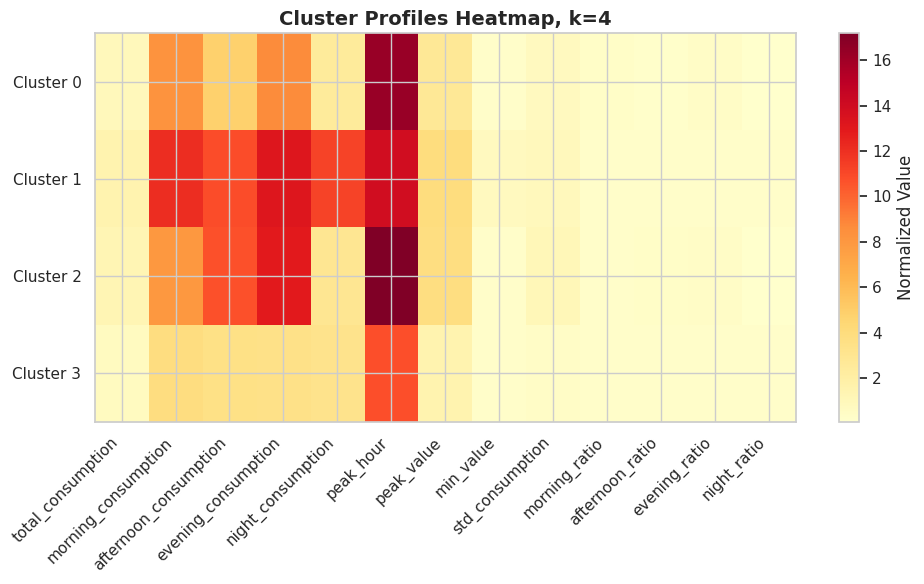

Αποθηκεύτηκε: ../results/cluster_heatmap_k4.png

✅ Visualization ολοκληρώθηκε!


In [60]:
# ═══════════════════════════════════════════════════════════════════════════════
# VISUALIZATION: CLUSTER PROFILES (AGGREGATED FEATURES)
# ═══════════════════════════════════════════════════════════════════════════════

# 1) Centroids (από KMeans) - AGGREGATED FEATURES
centroids = kmeans.cluster_centers_  # shape (k, num_features)

# Feature names
feature_names = list(profiles_24_norm.columns)

print(f"Centroids shape: {centroids.shape}")
print(f"Features: {feature_names}")

# Plot 1: Centroids (Bar plot για aggregated features)
fig, ax = plt.subplots(figsize=(12, 6))
x_pos = np.arange(len(feature_names))
width = 0.2

for c in range(chosen_k):
    offset = (c - chosen_k/2) * width
    ax.bar(x_pos + offset, centroids[c], width, label=f'Cluster {c}', alpha=0.8)

ax.set_title(f'KMeans Centroids (Aggregated Features), k={chosen_k}', fontsize=14, fontweight='bold')
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Normalized Value', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.legend()
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
centroids_plot = RESULTS_DIR / f'cluster_centroids_k{chosen_k}.png'
plt.savefig(centroids_plot, dpi=300, bbox_inches='tight')
plt.show()
print(f"Αποθηκεύτηκε: {centroids_plot}")


# 2) Μέσο προφίλ ανά συστάδα (Average aggregated features)
profiles_with_labels = profiles_24_norm.copy()
profiles_with_labels['cluster'] = labels
mean_profiles = profiles_with_labels.groupby('cluster').mean()

fig, ax = plt.subplots(figsize=(12, 6))
x_pos = np.arange(len(feature_names))
width = 0.2

for c in range(chosen_k):
    offset = (c - chosen_k/2) * width
    ax.bar(x_pos + offset, mean_profiles.loc[c].values, width, label=f'Cluster {c}', alpha=0.8)

ax.set_title(f'Average Aggregated Profiles per Cluster, k={chosen_k}', fontsize=14, fontweight='bold')
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Normalized Value', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.legend()
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
avg_plot = RESULTS_DIR / f'cluster_average_profiles_k{chosen_k}.png'
plt.savefig(avg_plot, dpi=300, bbox_inches='tight')
plt.show()
print(f"Αποθηκεύτηκε: {avg_plot}")


# 3) BONUS: Heatmap για να δούμε τις διαφορές
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(mean_profiles.values, cmap='YlOrRd', aspect='auto')

# Axes
ax.set_xticks(np.arange(len(feature_names)))
ax.set_yticks(np.arange(chosen_k))
ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.set_yticklabels([f'Cluster {c}' for c in range(chosen_k)])

# Colorbar
plt.colorbar(im, ax=ax, label='Normalized Value')

# Title
ax.set_title(f'Cluster Profiles Heatmap, k={chosen_k}', fontsize=14, fontweight='bold')

plt.tight_layout()
heatmap_plot = RESULTS_DIR / f'cluster_heatmap_k{chosen_k}.png'
plt.savefig(heatmap_plot, dpi=300, bbox_inches='tight')
plt.show()
print(f"Αποθηκεύτηκε: {heatmap_plot}")

print("\n✅ Visualization ολοκληρώθηκε!")

## Αντιπροσωπευτικές ημέρες ανά συστάδα

Επιλέγουμε για κάθε συστάδα τις 10 ημέρες που είναι πιο κοντά στο centroid (με Ευκλείδεια απόσταση) και προβάλλουμε τα προφίλ τους.
Αυτό βοηθά να δούμε “ρεαλιστικά” ημερήσια μοτίβα πίσω από τα centroids.

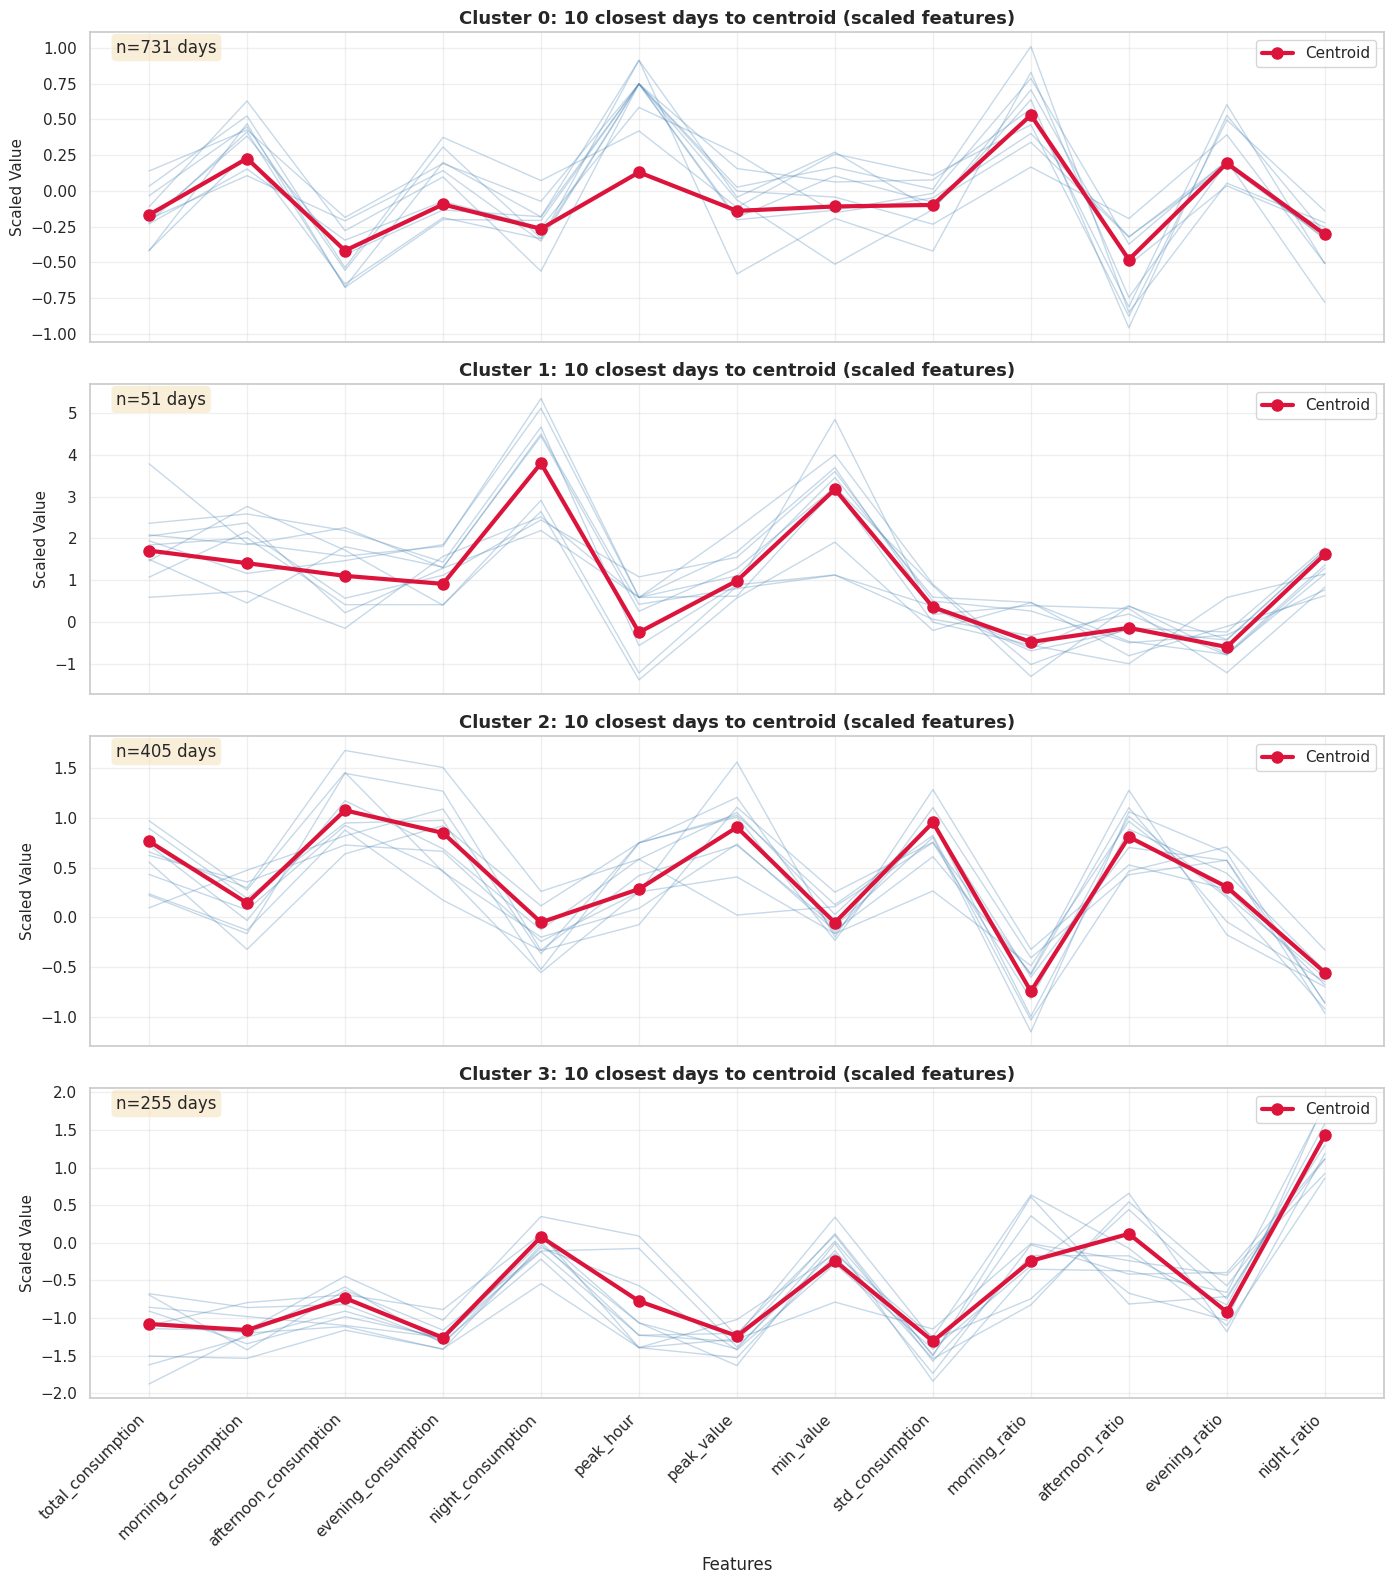

Αποθηκεύτηκε: ../results/cluster_representative_days_k4.png

📅 REPRESENTATIVE DATES PER CLUSTER:

Cluster 0 (top 5 closest to centroid):
  1. 2009-03-20 (Fri) 💼 - Spring
  2. 2010-04-08 (Thu) 💼 - Spring
  3. 2009-11-13 (Fri) 💼 - Autumn
  4. 2009-03-30 (Mon) 💼 - Spring
  5. 2010-11-23 (Tue) 💼 - Autumn

Cluster 1 (top 5 closest to centroid):
  1. 2007-01-14 (Sun) 🏖️ - Winter
  2. 2007-12-29 (Sat) 🏖️ - Winter
  3. 2009-02-23 (Mon) 💼 - Winter
  4. 2008-03-06 (Thu) 💼 - Spring
  5. 2006-12-17 (Sun) 🏖️ - Winter

Cluster 2 (top 5 closest to centroid):
  1. 2007-03-17 (Sat) 🏖️ - Spring
  2. 2009-10-10 (Sat) 🏖️ - Autumn
  3. 2008-03-21 (Fri) 💼 - Spring
  4. 2007-10-23 (Tue) 💼 - Autumn
  5. 2008-12-07 (Sun) 🏖️ - Winter

Cluster 3 (top 5 closest to centroid):
  1. 2010-03-02 (Tue) 💼 - Spring
  2. 2009-08-14 (Fri) 💼 - Summer
  3. 2009-02-18 (Wed) 💼 - Winter
  4. 2009-07-27 (Mon) 💼 - Summer
  5. 2010-07-16 (Fri) 💼 - Summer

✅ Representative days visualization ολοκληρώθηκε!


In [62]:
# ═══════════════════════════════════════════════════════════════════════════════
# REPRESENTATIVE DAYS: Closest to Centroid (AGGREGATED FEATURES)
# ═══════════════════════════════════════════════════════════════════════════════

from numpy.linalg import norm

# Recreate X_scaled (γιατί είναι local variable στο προηγούμενο cell)
scaler_viz = StandardScaler()
X_scaled_viz = scaler_viz.fit_transform(profiles_24_norm.values)

def closest_days_to_centroid(X, labels, centroid, cluster_id, n=10):
    """Βρίσκει τις n πιο κοντινές ημέρες στο centroid"""
    idx = np.where(labels == cluster_id)[0]
    Xc = X[idx]
    d = norm(Xc - centroid[None, :], axis=1)
    order = np.argsort(d)
    chosen_idx = idx[order[:n]]
    return chosen_idx

# Feature names για το x-axis
feature_names = list(profiles_24_norm.columns)
x_pos = np.arange(len(feature_names))

# Plot: Representative days per cluster
fig, axes = plt.subplots(chosen_k, 1, figsize=(14, 4*chosen_k), sharex=True)
if chosen_k == 1:
    axes = [axes]

for c in range(chosen_k):
    # Βρες τις 10 πιο κοντινές ημέρες
    sel = closest_days_to_centroid(X_scaled_viz, labels, centroids[c], c, n=10)
    
    # Plot όλες τις κοντινές ημέρες (ελαφρύ μπλε)
    for i in sel:
        axes[c].plot(x_pos, X_scaled_viz[i], color='steelblue', alpha=0.3, linewidth=1)
    
    # Plot το centroid (κόκκινο, bold)
    axes[c].plot(x_pos, centroids[c], color='crimson', linewidth=3, 
                 label='Centroid', marker='o', markersize=8)
    
    # Styling
    axes[c].set_title(f'Cluster {c}: 10 closest days to centroid (scaled features)', 
                      fontsize=13, fontweight='bold')
    axes[c].grid(alpha=0.3)
    axes[c].legend(loc='upper right')
    axes[c].set_ylabel('Scaled Value', fontsize=11)
    
    # Προσθήκη cluster size info
    cluster_size = len(np.where(labels == c)[0])
    axes[c].text(0.02, 0.98, f'n={cluster_size} days', 
                 transform=axes[c].transAxes, 
                 verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# X-axis labels (μόνο στο τελευταίο subplot)
axes[-1].set_xlabel('Features', fontsize=12)
axes[-1].set_xticks(x_pos)
axes[-1].set_xticklabels(feature_names, rotation=45, ha='right')

plt.tight_layout()
rep_plot = RESULTS_DIR / f'cluster_representative_days_k{chosen_k}.png'
plt.savefig(rep_plot, dpi=300, bbox_inches='tight')
plt.show()
print(f"Αποθηκεύτηκε: {rep_plot}")

# BONUS: Print representative dates per cluster
print("\n📅 REPRESENTATIVE DATES PER CLUSTER:")
print("="*80)
for c in range(chosen_k):
    sel = closest_days_to_centroid(X_scaled_viz, labels, centroids[c], c, n=5)
    dates = profiles_24_norm.index[sel]
    print(f"\nCluster {c} (top 5 closest to centroid):")
    for i, date in enumerate(dates, 1):
        # Get metadata
        day_of_week = meta.loc[date, 'DayOfWeek']
        is_weekend = meta.loc[date, 'IsWeekend']
        season = meta.loc[date, 'Season']
        day_name = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'][day_of_week]
        weekend_flag = '🏖️' if is_weekend else '💼'
        
        print(f"  {i}. {date.strftime('%Y-%m-%d')} ({day_name}) {weekend_flag} - {season}")

print("\n✅ Representative days visualization ολοκληρώθηκε!")

## Ερμηνεία συστάδων με βάση Season και IsWeekend

Θα εξετάσουμε τις κατανομές των συστάδων ανά:
- Εποχή (Winter, Spring, Summer, Autumn)
- Εργάσιμη vs Σαββατοκύριακο

Στόχος: Να ερμηνεύσουμε τις συστάδες (π.χ. “Συστάδα 2 → ΣΚ με βραδινές αιχμές”, “Συστάδα 1 → χειμωνιάτικες ημέρες με υψηλές βραδινές καταναλώσεις”).

Κατανομή ανά Season:


Season,Autumn,Spring,Summer,Winter
cluster,,,,
0,94,94,69,120
1,27,41,121,43
2,110,90,82,71
3,128,143,96,111



Κατανομή ανά IsWeekend (0=εργάσιμη, 1=ΣΚ):


IsWeekend,0,1
cluster,,
0,148,229
1,129,103
2,322,31
3,430,48


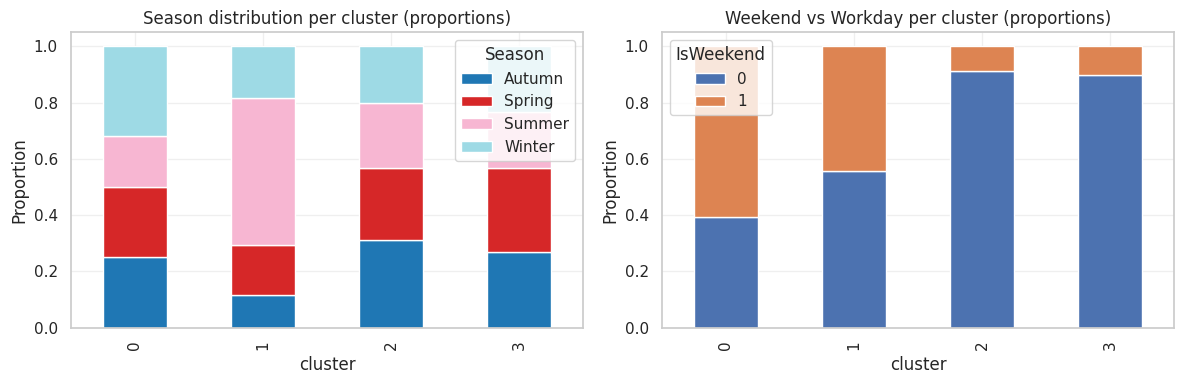

Αποθηκεύτηκε: ../results/cluster_interpretation_k4.png


In [63]:
# Πίνακες κατανομών
by_season = clustered.groupby(['cluster', 'Season']).size().unstack(fill_value=0)
by_weekend = clustered.groupby(['cluster', 'IsWeekend']).size().unstack(fill_value=0)

print("Κατανομή ανά Season:")
display(by_season)

print("\nΚατανομή ανά IsWeekend (0=εργάσιμη, 1=ΣΚ):")
display(by_weekend)

# Stacked barplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

(by_season.div(by_season.sum(axis=1), axis=0)).plot(kind='bar', stacked=True, ax=axes[0], colormap='tab20')
axes[0].set_title('Season distribution per cluster (proportions)')
axes[0].set_ylabel('Proportion')
axes[0].grid(alpha=0.3)

(by_weekend.div(by_weekend.sum(axis=1), axis=0)).plot(kind='bar', stacked=True, ax=axes[1], color=['#4c72b0', '#dd8452'])
axes[1].set_title('Weekend vs Workday per cluster (proportions)')
axes[1].set_ylabel('Proportion')
axes[1].grid(alpha=0.3)

plt.tight_layout()
interp_plot = RESULTS_DIR / f'cluster_interpretation_k{chosen_k}.png'
plt.savefig(interp_plot, dpi=300, bbox_inches='tight')
plt.show()
print(f"Αποθηκεύτηκε: {interp_plot}")

# Ομαδοποίηση Ημερήσιων Προφίλ Κατανάλωσης: Σύνοψη και Ερμηνεία (k=4)

## Περιγραφή Μεθοδολογίας
- Δημιουργήθηκαν ωριαία προφίλ 24 διαστάσεων (kWh/ώρα) ανά ημέρα.
- Κανονικοποίηση ανά ημέρα (το άθροισμα των 24 ωρών = 1) ώστε η ομαδοποίηση να βασίζεται στο σχήμα του μοτίβου και όχι στο απόλυτο επίπεδο κατανάλωσης.
- Εφαρμόστηκε KMeans για k∈[2..10]. Επιλογή k=4 ως συμβιβασμός μεταξύ ερμηνευσιμότητας και μετρικών.
- Αξιολόγηση με Silhouette Score και Davies–Bouldin Index.

## Μετρικές για k=4
- Silhouette ≈ 0.104
- Davies–Bouldin ≈ 2.223
Σχόλιο: Οι τιμές αυτές είναι σύμφωνες με τη φύση των 24-διάστατων normalized προφίλ. Δεν υποδηλώνουν πρόβλημα. Το k=2 είχε υψηλότερο Silhouette, αλλά το k=4 προσφέρει σαφέστερη ερμηνεία προτύπων.

## Περιγραφές Συστάδων
- Cluster 0
  - Χαρακτηριστικά: Σταδιακή άνοδος μέσα στην ημέρα και έντονη βραδινή αιχμή (18–21h).
  - Ερμηνεία: Ημέρες με συγκέντρωση δραστηριοτήτων αργά το απόγευμα/βράδυ. Ση

# Εξόρυξη Κανόνων Συσχέτισης

Στόχος: Ανακάλυψη συχνών προτύπων και κανόνων που συνδέουν:
- Χρήση υπομετρητών (Sub_metering_1/2/3) και χρονικών περιόδων (Night/Morning/Afternoon/Peak)
- Με εποχικότητα/ημέρα εβδομάδας (Season, IsWeekend)
- Με υψηλή ημερήσια κατανάλωση (High Daily_total_power)

Μεθοδολογία:
1. Φόρτωση ημερήσιων συνόψεων (train/val/test) από το preprocessing.
2. Διακριτοποίηση συνεχών χαρακτηριστικών σε Low/Medium/High με ποσοστημόρια του train.
3. Κωδικοποίηση συναλλαγών (one-hot items).
4. Apriori για συχνά σύνολα, `association_rules` για κανόνες. Εστίαση σε κανόνες με συνέπεια `High_Daily_total_power`.
5. Αξιολόγηση με Support, Confidence, Lift. Έλεγχος στα val/test για γενίκευση

In [45]:
import pandas as pd
import numpy as np
from pathlib import Path

from mlxtend.frequent_patterns import apriori, association_rules
# προαιρετικά: from mlxtend.frequent_patterns import fpgrowth

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

DATA_DIR = Path('..') / 'data'
RESULTS_DIR = Path('..') / 'results'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Data dir: {DATA_DIR.resolve()}")
print(f"Results dir: {RESULTS_DIR.resolve()}")

Data dir: /home/konstantinos-papadogiannis/energy-data-mining/data
Results dir: /home/konstantinos-papadogiannis/energy-data-mining/results


In [46]:
train = pd.read_csv(DATA_DIR / 'train_raw.csv', parse_dates=True, index_col=0)
val   = pd.read_csv(DATA_DIR / 'val_raw.csv',   parse_dates=True, index_col=0)
test  = pd.read_csv(DATA_DIR / 'test_raw.csv',  parse_dates=True, index_col=0)

print("Shapes:", train.shape, val.shape, test.shape)
print("Columns:", list(train.columns)[:8], "...")

needed = [
    'Daily_total_power',
    'Sub_metering_1_sum', 'Sub_metering_2_sum', 'Sub_metering_3_sum',
    'Nighttime_usage', 'Morning_usage', 'Afternoon_usage', 'Peak_hour_power',
    'Season', 'IsWeekend'
]
missing = [c for c in needed if c not in train.columns]
assert not missing, f"Λείπουν στήλες: {missing}"

Shapes: (987, 48) (210, 48) (213, 48)
Columns: ['Daily_total_power', 'Daily_mean_power', 'Daily_peak_power', 'Daily_min_power', 'Daily_std_power', 'Global_reactive_power_sum', 'Global_reactive_power_mean', 'Voltage_mean'] ...


## Διακριτοποίηση

- Για συνεχείς μεταβλητές θα ορίσουμε Low/Medium/High με ποσοστημόρια από το **train** (χωρίς leakage).
- Θα χρησιμοποιήσουμε q=[0.33, 0.66] για τριπλή κατηγορία.
- Για τον στόχο `High_Daily_total_power`: ορίζουμε **High** ως πάνω από το 75ο ποσοστημόριο του train.
- Θα διατηρήσουμε επίσης δυαδικά items για χρονικές περιόδους: High_Night, High_Morning, High_Afternoon, High_Peak (βασισμένα σε q66 του train για κάθε περίοδο).

In [47]:
# Βοηθός για thresholds
def quantile_thresholds(s, q_low=0.33, q_high=0.66):
    return s.quantile(q_low), s.quantile(q_high)

# Submeterings
th_sub1 = quantile_thresholds(train['Sub_metering_1_sum'])
th_sub2 = quantile_thresholds(train['Sub_metering_2_sum'])
th_sub3 = quantile_thresholds(train['Sub_metering_3_sum'])

# Period usages
th_night    = quantile_thresholds(train['Nighttime_usage'])
th_morning  = quantile_thresholds(train['Morning_usage'])
th_afternoon= quantile_thresholds(train['Afternoon_usage'])
th_peak     = quantile_thresholds(train['Peak_hour_power'])

# Target threshold (πιο αυστηρό για “High”)
th_target_high = train['Daily_total_power'].quantile(0.75)

summary = pd.DataFrame({
    'feature': [
        'Sub_metering_1_sum','Sub_metering_2_sum','Sub_metering_3_sum',
        'Nighttime_usage','Morning_usage','Afternoon_usage','Peak_hour_power',
        'Daily_total_power (target)'
    ],
    'q33': [
        th_sub1[0], th_sub2[0], th_sub3[0],
        th_night[0], th_morning[0], th_afternoon[0], th_peak[0],
        np.nan
    ],
    'q66': [
        th_sub1[1], th_sub2[1], th_sub3[1],
        th_night[1], th_morning[1], th_afternoon[1], th_peak[1],
        np.nan
    ],
    'q75_target': [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, th_target_high]
}).round(3)

summary

,feature,q33,q66,q75_target
0,Sub_metering_1_sum,958.760,1878.800,NaN
1,Sub_metering_2_sum,483.760,2280.040,NaN
2,Sub_metering_3_sum,7169.140,10161.560,NaN
3,Nighttime_usage,3.959,5.399,NaN
4,Morning_usage,5.846,8.915,NaN
5,Afternoon_usage,3.437,7.257,NaN
6,Peak_hour_power,4.934,8.001,NaN
7,Daily_total_power (target),NaN,NaN,31.357


In [48]:
def make_transactions(df, thresholds):
    (
        th_sub1, th_sub2, th_sub3,
        th_night, th_morning, th_afternoon, th_peak,
        th_target_high
    ) = thresholds
    
    tx = pd.DataFrame(index=df.index)

    # Binning Sub_meterings σε L/M/H
    def to_lmh(x, q33, q66):
        if x <= q33: return 'Low'
        if x <= q66: return 'Medium'
        return 'High'
    
    tx['Sub1_LMH'] = df['Sub_metering_1_sum'].apply(lambda x: to_lmh(x, *th_sub1))
    tx['Sub2_LMH'] = df['Sub_metering_2_sum'].apply(lambda x: to_lmh(x, *th_sub2))
    tx['Sub3_LMH'] = df['Sub_metering_3_sum'].apply(lambda x: to_lmh(x, *th_sub3))

    # High usage flags per period (άνω του q66 → High)
    tx['High_Night']     = (df['Nighttime_usage']   > th_night[1]).astype(int)
    tx['High_Morning']   = (df['Morning_usage']     > th_morning[1]).astype(int)
    tx['High_Afternoon'] = (df['Afternoon_usage']   > th_afternoon[1]).astype(int)
    tx['High_Peak']      = (df['Peak_hour_power']   > th_peak[1]).astype(int)

    # Categorical Season, IsWeekend
    tx['Season'] = df['Season'].astype(str)
    tx['IsWeekend'] = df['IsWeekend'].astype(int)

    # Target: High Daily_total_power (άνω του q75 του train)
    tx['High_Daily_total_power'] = (df['Daily_total_power'] > th_target_high).astype(int)

    # One-hot κωδικοποίηση σε items
    items = pd.DataFrame(index=df.index)

    # LMH items
    for col in ['Sub1_LMH','Sub2_LMH','Sub3_LMH']:
        d = pd.get_dummies(tx[col], prefix=col)
        items = pd.concat([items, d], axis=1)

    # Period flags
    for col in ['High_Night','High_Morning','High_Afternoon','High_Peak']:
        items[col] = tx[col].astype(int)

    # Season
    items = pd.concat([items, pd.get_dummies(tx['Season'], prefix='Season')], axis=1)

    # Weekend
    items['IsWeekend_1'] = (tx['IsWeekend'] == 1).astype(int)
    items['IsWeekend_0'] = (tx['IsWeekend'] == 0).astype(int)

    # Target ως ξεχωριστό δυαδικό item
    items['High_Daily_total_power'] = tx['High_Daily_total_power']

    # Βεβαίωση ότι όλα είναι 0/1
    items = items.fillna(0).astype(int)
    return items

thresholds = (th_sub1, th_sub2, th_sub3, th_night, th_morning, th_afternoon, th_peak, th_target_high)

items_train = make_transactions(train, thresholds)
items_val   = make_transactions(val, thresholds)
items_test  = make_transactions(test, thresholds)

print(items_train.shape, items_val.shape, items_test.shape)
items_train.head()

(987, 20) (210, 19) (213, 19)


,Sub1_LMH_High,Sub1_LMH_Low,Sub1_LMH_Medium,Sub2_LMH_High,Sub2_LMH_Low,Sub2_LMH_Medium,Sub3_LMH_High,Sub3_LMH_Low,Sub3_LMH_Medium,High_Night,High_Morning,High_Afternoon,High_Peak,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,IsWeekend_1,IsWeekend_0,High_Daily_total_power
DateTime,,,,,,,,,,,,,,,,,,,,
2007-01-15,0,0,1,0,0,1,1,0,0,1,1,1,1,0,0,0,1,0,1,1
2007-01-16,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0
2007-01-17,1,0,0,1,0,0,1,0,0,1,1,1,1,0,0,0,1,0,1,1
2007-01-18,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0
2007-01-19,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,1,0,1,0


## Apriori και κανόνες

- Εξάγουμε συχνά σύνολα με `apriori` πάνω στο train items (min_support π.χ. 0.08–0.15).
- Παράγουμε κανόνες με `association_rules`, φιλτράρουμε να έχουν συνέπεια (consequent) `High_Daily_total_power`.
- Ταξινομούμε κατά Lift και Confidence.

In [49]:
min_sup = 0.10   # μπορείς να το προσαρμόσεις (0.08–0.15)
min_conf = 0.60  # κατώφλι εμπιστοσύνης

freq = apriori(items_train, min_support=min_sup, use_colnames=True)
rules = association_rules(freq, metric='confidence', min_threshold=min_conf)

# Φιλτράρισμα για κανόνες όπου το consequent είναι High_Daily_total_power
rules_target = rules[rules['consequents'].apply(lambda s: 'High_Daily_total_power' in list(s))].copy()

# Ταξινόμηση κατά lift, κατόπιν confidence
rules_target = rules_target.sort_values(['lift','confidence','support'], ascending=False)

print("Σύνολο κανόνων:", len(rules))
print("Κανόνες με συνέπεια High_Daily_total_power:", len(rules_target))
display(rules_target.head(10)[['antecedents','consequents','support','confidence','lift']])

# Αποθήκευση
rules_path = RESULTS_DIR / 'association_rules_high_total.csv'
rules_target.to_csv(rules_path, index=False)
print(f"Αποθηκεύτηκαν οι κανόνες στο: {rules_path}")

Σύνολο κανόνων: 252
Κανόνες με συνέπεια High_Daily_total_power: 49


/home/konstantinos-papadogiannis/energy-data-mining/venv/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,support,confidence,lift
195,"(High_Afternoon, High_Peak)","(Sub1_LMH_High, High_Daily_total_power)",0.113,0.615,4.022
214,"(High_Afternoon, High_Peak)","(Sub2_LMH_High, High_Daily_total_power)",0.124,0.670,3.892
246,"(High_Night, High_Afternoon, High_Peak)",(High_Daily_total_power),0.107,0.964,3.851
238,"(High_Afternoon, Sub3_LMH_High, High_Peak)",(High_Daily_total_power),0.128,0.947,3.786
227,"(High_Afternoon, High_Morning)","(Sub3_LMH_High, High_Daily_total_power)",0.117,0.697,3.780
209,"(Sub2_LMH_High, High_Afternoon, High_Peak)",(High_Daily_total_power),0.124,0.946,3.779
241,"(High_Afternoon, High_Peak)","(Sub3_LMH_High, High_Daily_total_power)",0.128,0.692,3.754
191,"(Sub1_LMH_High, High_Afternoon, High_Peak)",(High_Daily_total_power),0.113,0.918,3.668
204,"(Sub2_LMH_High, Sub3_LMH_High, High_Peak)",(High_Daily_total_power),0.101,0.917,3.666
177,"(High_Afternoon, High_Peak)",(High_Daily_total_power),0.168,0.912,3.645


Αποθηκεύτηκαν οι κανόνες στο: ../results/association_rules_high_total.csv


## Έλεγχος κανόνων σε Validation/Test

Για τους top-N κανόνες, υπολογίζουμε εμπειρικό confidence και support σε val και test, ώστε να δούμε αν οι κανόνες γενικεύουν (όχι απλώς train-specific).

In [50]:
def evaluate_rules_on(items_df, rules_df, top_n=15):
    res = []
    for _, row in rules_df.head(top_n).iterrows():
        ants = list(row['antecedents'])
        cons = list(row['consequents'])
        # antecedent match
        ant_mask = items_df[ants].all(axis=1)
        # consequent true
        cons_mask = items_df[cons].all(axis=1)
        n_ant = ant_mask.sum()
        n_both = (ant_mask & cons_mask).sum()
        support = n_both / len(items_df)
        confidence = (n_both / n_ant) if n_ant > 0 else np.nan
        res.append({
            'antecedents': tuple(ants),
            'consequents': tuple(cons),
            'support': support,
            'confidence': confidence,
            'n_antecedent': int(n_ant),
            'n_both': int(n_both)
        })
    return pd.DataFrame(res)

eval_val  = evaluate_rules_on(items_val,  rules_target, top_n=15)
eval_test = evaluate_rules_on(items_test, rules_target, top_n=15)

print("Validation:")
display(eval_val)

print("\nTest:")
display(eval_test)

# Αποθήκευση
eval_val.to_csv(RESULTS_DIR / 'association_rules_eval_val.csv', index=False)
eval_test.to_csv(RESULTS_DIR / 'association_rules_eval_test.csv', index=False)
print("Αποθηκεύτηκαν τα evaluation αρχεία.")

Validation:


,antecedents,consequents,support,confidence,n_antecedent,n_both
0,"(High_Afternoon, High_Peak)","(Sub1_LMH_High, High_Daily_total_power)",0.171,0.590,61,36
1,"(High_Afternoon, High_Peak)","(Sub2_LMH_High, High_Daily_total_power)",0.124,0.426,61,26
2,"(High_Night, High_Afternoon, High_Peak)","(High_Daily_total_power,)",0.171,0.923,39,36
3,"(High_Afternoon, Sub3_LMH_High, High_Peak)","(High_Daily_total_power,)",0.205,0.860,50,43
4,"(High_Afternoon, High_Morning)","(Sub3_LMH_High, High_Daily_total_power)",0.219,0.697,66,46
5,"(Sub2_LMH_High, High_Afternoon, High_Peak)","(High_Daily_total_power,)",0.124,0.788,33,26
6,"(High_Afternoon, High_Peak)","(Sub3_LMH_High, High_Daily_total_power)",0.205,0.705,61,43
7,"(Sub1_LMH_High, High_Afternoon, High_Peak)","(High_Daily_total_power,)",0.171,0.878,41,36
8,"(Sub2_LMH_High, Sub3_LMH_High, High_Peak)","(High_Daily_total_power,)",0.100,0.875,24,21
9,"(High_Afternoon, High_Peak)","(High_Daily_total_power,)",0.233,0.803,61,49



Test:


,antecedents,consequents,support,confidence,n_antecedent,n_both
0,"(High_Afternoon, High_Peak)","(Sub1_LMH_High, High_Daily_total_power)",0.052,0.524,21,11
1,"(High_Afternoon, High_Peak)","(Sub2_LMH_High, High_Daily_total_power)",0.033,0.333,21,7
2,"(High_Night, High_Afternoon, High_Peak)","(High_Daily_total_power,)",0.047,0.833,12,10
3,"(High_Afternoon, Sub3_LMH_High, High_Peak)","(High_Daily_total_power,)",0.056,0.706,17,12
4,"(High_Afternoon, High_Morning)","(Sub3_LMH_High, High_Daily_total_power)",0.033,0.389,18,7
5,"(Sub2_LMH_High, High_Afternoon, High_Peak)","(High_Daily_total_power,)",0.033,0.700,10,7
6,"(High_Afternoon, High_Peak)","(Sub3_LMH_High, High_Daily_total_power)",0.056,0.571,21,12
7,"(Sub1_LMH_High, High_Afternoon, High_Peak)","(High_Daily_total_power,)",0.052,0.647,17,11
8,"(Sub2_LMH_High, Sub3_LMH_High, High_Peak)","(High_Daily_total_power,)",0.042,0.900,10,9
9,"(High_Afternoon, High_Peak)","(High_Daily_total_power,)",0.066,0.667,21,14


Αποθηκεύτηκαν τα evaluation αρχεία.


## Ερμηνεία κανόνων

- Παράδειγμα (ενδεικτικό):
  - Αν `Sub3_LMH=High` ΚΑΙ `IsWeekend_1=1` → `High_Daily_total_power`
    - Υψηλό Lift (>1) και Confidence (>0.6) υποδηλώνουν θετική συσχέτιση.
- Ερμηνεία σε σχέση με εκφώνηση:
  - Οι κανόνες δείχνουν συσχετίσεις ανάμεσα σε υψηλή χρήση συγκεκριμένων ζωνών/περιόδων και τη συνολική ημερήσια κατανάλωση.
  - Οι μετρικές Support/Confidence/Lift αναφέρονται ρητά και συνοδεύονται από έλεγχο val/test.

Σχόλια:
- Αν οι κανόνες είναι λίγοι/αδύναμοι, μείωσε `min_support` ή/και `min_confidence` προσεκτικά.
- Προαιρετικά μπορεί να χρησιμοποιηθεί FP-Growth (ταχύτερο σε κάποια σενάρια) με τα ίδια thresholds.

In [51]:
# Μετατροπή σε bool (απαιτείται/συνίσταται για mlxtend)
items_train_bool = items_train.astype(bool)
items_val_bool   = items_val.astype(bool)
items_test_bool  = items_test.astype(bool)

min_sup = 0.10
min_conf = 0.60

freq = apriori(items_train_bool, min_support=min_sup, use_colnames=True)
rules = association_rules(freq, metric='confidence', min_threshold=min_conf)

rules_target = rules[rules['consequents'].apply(lambda s: 'High_Daily_total_power' in list(s))].copy()
rules_target = rules_target.sort_values(['lift','confidence','support'], ascending=False)

print("Κανόνες με συνέπεια High_Daily_total_power:", len(rules_target))
display(rules_target.head(15)[['antecedents','consequents','support','confidence','lift']])

Κανόνες με συνέπεια High_Daily_total_power: 49


,antecedents,consequents,support,confidence,lift
195,"(High_Afternoon, High_Peak)","(Sub1_LMH_High, High_Daily_total_power)",0.113,0.615,4.022
214,"(High_Afternoon, High_Peak)","(Sub2_LMH_High, High_Daily_total_power)",0.124,0.670,3.892
246,"(High_Night, High_Afternoon, High_Peak)",(High_Daily_total_power),0.107,0.964,3.851
238,"(High_Afternoon, Sub3_LMH_High, High_Peak)",(High_Daily_total_power),0.128,0.947,3.786
227,"(High_Afternoon, High_Morning)","(Sub3_LMH_High, High_Daily_total_power)",0.117,0.697,3.780
209,"(Sub2_LMH_High, High_Afternoon, High_Peak)",(High_Daily_total_power),0.124,0.946,3.779
241,"(High_Afternoon, High_Peak)","(Sub3_LMH_High, High_Daily_total_power)",0.128,0.692,3.754
191,"(Sub1_LMH_High, High_Afternoon, High_Peak)",(High_Daily_total_power),0.113,0.918,3.668
204,"(Sub2_LMH_High, Sub3_LMH_High, High_Peak)",(High_Daily_total_power),0.101,0.917,3.666
177,"(High_Afternoon, High_Peak)",(High_Daily_total_power),0.168,0.912,3.645


In [52]:
def frozenset_to_str(fs):
    return " ∧ ".join(sorted(list(fs)))

top_rules = rules_target.head(15).copy()
top_rules['antecedents_str'] = top_rules['antecedents'].apply(frozenset_to_str)
top_rules['consequents_str'] = top_rules['consequents'].apply(frozenset_to_str)
cols_out = ['antecedents_str','consequents_str','support','confidence','lift']
display(top_rules[cols_out])

top_rules_path = RESULTS_DIR / 'association_rules_high_total_top15.csv'
top_rules[cols_out].to_csv(top_rules_path, index=False)
print(f"Αποθηκεύτηκαν οι top κανόνες στο: {top_rules_path}")

,antecedents_str,consequents_str,support,confidence,lift
195,High_Afternoon ∧ High_Peak,High_Daily_total_power ∧ Sub1_LMH_High,0.113,0.615,4.022
214,High_Afternoon ∧ High_Peak,High_Daily_total_power ∧ Sub2_LMH_High,0.124,0.670,3.892
246,High_Afternoon ∧ High_Night ∧ High_Peak,High_Daily_total_power,0.107,0.964,3.851
238,High_Afternoon ∧ High_Peak ∧ Sub3_LMH_High,High_Daily_total_power,0.128,0.947,3.786
227,High_Afternoon ∧ High_Morning,High_Daily_total_power ∧ Sub3_LMH_High,0.117,0.697,3.780
209,High_Afternoon ∧ High_Peak ∧ Sub2_LMH_High,High_Daily_total_power,0.124,0.946,3.779
241,High_Afternoon ∧ High_Peak,High_Daily_total_power ∧ Sub3_LMH_High,0.128,0.692,3.754
191,High_Afternoon ∧ High_Peak ∧ Sub1_LMH_High,High_Daily_total_power,0.113,0.918,3.668
204,High_Peak ∧ Sub2_LMH_High ∧ Sub3_LMH_High,High_Daily_total_power,0.101,0.917,3.666
177,High_Afternoon ∧ High_Peak,High_Daily_total_power,0.168,0.912,3.645


Αποθηκεύτηκαν οι top κανόνες στο: ../results/association_rules_high_total_top15.csv


✅ Using existing top_rules from previous cell

📊 Creating visualizations for top 10 rules...


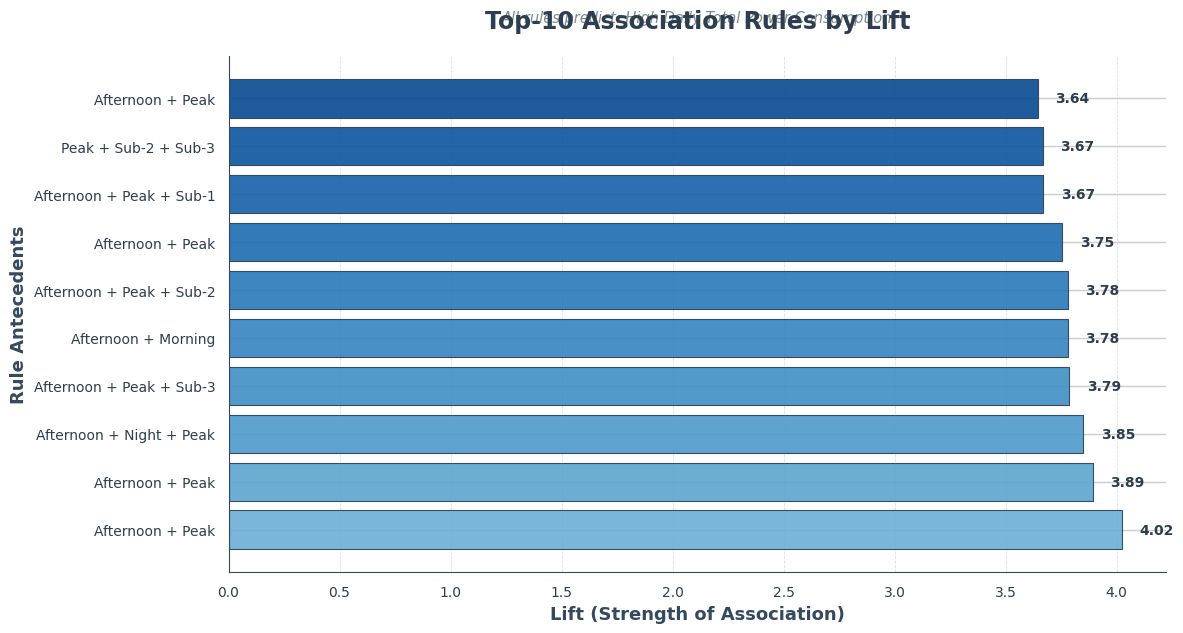

✅ Saved: ../results/ar_top10_lift_improved.png


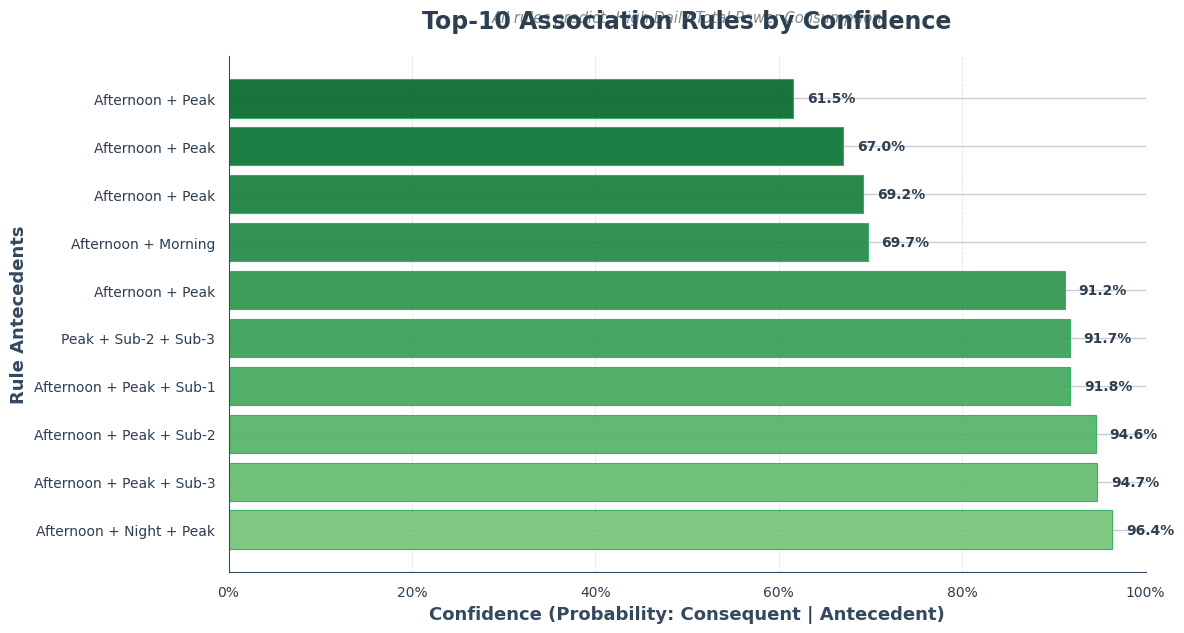

✅ Saved: ../results/ar_top10_confidence_improved.png

🎉 Improved visualizations created successfully!


In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

# ═══════════════════════════════════════════════════════════════
# ΠΡΟΕΤΟΙΜΑΣΙΑ ΔΕΔΟΜΕΝΩΝ
# ═══════════════════════════════════════════════════════════════

# Ελέγχος αν υπάρχει το top_rules
try:
    top_rules
    cols_out
    print("✅ Using existing top_rules from previous cell")
except NameError:
    print("⚠️  top_rules not found. Loading from CSV...")
    
    # Φόρτωση από CSV
    RESULTS_DIR = Path('..') / 'results'
    top_rules = pd.read_csv(RESULTS_DIR / 'association_rules_high_total_top15.csv')
    cols_out = ['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift']
    
    print(f"✅ Loaded {len(top_rules)} rules from CSV")

# Προετοιμασία δεδομένων
plot_df = top_rules[cols_out].copy()
plot_df = plot_df.sort_values('lift', ascending=False).head(10)

# Συντομότερες ετικέτες
def shorten_rule(rule_str):
    """Μετατροπή 'High_Afternoon ∧ High_Peak' σε 'Afternoon + Peak'"""
    # Αφαίρεση High_ prefix
    parts = rule_str.split(' ∧ ')
    cleaned = []
    for p in parts:
        # Αφαίρεση High_, _LMH_High, Sub -> Sub-
        p = p.replace('High_', '').replace('_LMH_High', '')
        p = p.replace('Sub_metering_', 'Sub-')
        p = p.replace('Sub', 'Sub-')
        cleaned.append(p)
    return ' + '.join(cleaned)

plot_df['short_antecedents'] = plot_df['antecedents_str'].apply(shorten_rule)

print(f"\n📊 Creating visualizations for top {len(plot_df)} rules...")

# ═══════════════════════════════════════════════════════════════
# PLOT 1: LIFT
# ═══════════════════════════════════════════════════════════════

fig, ax = plt.subplots(figsize=(12, 6.5))

# Χρωματική κλίμακα (gradient)
colors = plt.cm.Blues(np.linspace(0.5, 0.9, len(plot_df)))

# Barplot (horizontal)
bars = ax.barh(range(len(plot_df)), plot_df['lift'], 
               color=colors, edgecolor='#2c3e50', linewidth=0.8, alpha=0.9)

# Ετικέτες Y
ax.set_yticks(range(len(plot_df)))
ax.set_yticklabels(plot_df['short_antecedents'], fontsize=11, fontweight='500')

# Τίτλοι και labels
ax.set_title('Top-10 Association Rules by Lift', 
             fontsize=17, fontweight='bold', pad=20, color='#2c3e50')
ax.set_xlabel('Lift (Strength of Association)', 
              fontsize=13, fontweight='600', color='#34495e')
ax.set_ylabel('Rule Antecedents', 
              fontsize=13, fontweight='600', color='#34495e')

# Grid για ευκολότερη ανάγνωση
ax.grid(axis='x', alpha=0.25, linestyle='--', linewidth=0.6, color='gray')
ax.set_axisbelow(True)

# Προσθήκη τιμών στα bars
for i, (idx, row) in enumerate(plot_df.iterrows()):
    ax.text(row['lift'] + 0.08, i, f"{row['lift']:.2f}", 
            va='center', ha='left', fontsize=10, 
            fontweight='bold', color='#2c3e50')

# Subtitle (εξήγηση)
ax.text(0.5, 1.06, 'All rules predict: High Daily Total Power Consumption', 
        ha='center', va='bottom', transform=ax.transAxes, 
        fontsize=10.5, style='italic', color='#7f8c8d')

# Styling (αφαίρεση περιττών spines)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['left'].set_color('#34495e')
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['bottom'].set_color('#34495e')

# Tick styling
ax.tick_params(axis='both', which='major', labelsize=10, colors='#2c3e50')

plt.tight_layout()

# Αποθήκευση
try:
    RESULTS_DIR
except NameError:
    RESULTS_DIR = Path('..') / 'results'

lift_plot = RESULTS_DIR / 'ar_top10_lift_improved.png'
plt.savefig(lift_plot, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()
print(f"✅ Saved: {lift_plot}")

# ═══════════════════════════════════════════════════════════════
# PLOT 2: CONFIDENCE
# ═══════════════════════════════════════════════════════════════

fig, ax = plt.subplots(figsize=(12, 6.5))

# Ταξινόμηση κατά confidence
plot_df_conf = plot_df.sort_values('confidence', ascending=False)

# Χρωματική κλίμακα (gradient πράσινο)
colors = plt.cm.Greens(np.linspace(0.5, 0.9, len(plot_df_conf)))

# Barplot (horizontal)
bars = ax.barh(range(len(plot_df_conf)), plot_df_conf['confidence'], 
               color=colors, edgecolor='#27ae60', linewidth=0.8, alpha=0.9)

# Ετικέτες Y
ax.set_yticks(range(len(plot_df_conf)))
ax.set_yticklabels(plot_df_conf['short_antecedents'], fontsize=11, fontweight='500')

# Τίτλοι και labels
ax.set_title('Top-10 Association Rules by Confidence', 
             fontsize=17, fontweight='bold', pad=20, color='#2c3e50')
ax.set_xlabel('Confidence (Probability: Consequent | Antecedent)', 
              fontsize=13, fontweight='600', color='#34495e')
ax.set_ylabel('Rule Antecedents', 
              fontsize=13, fontweight='600', color='#34495e')

# Grid
ax.grid(axis='x', alpha=0.25, linestyle='--', linewidth=0.6, color='gray')
ax.set_axisbelow(True)

# Προσθήκη τιμών στα bars (ως ποσοστά)
for i, (idx, row) in enumerate(plot_df_conf.iterrows()):
    ax.text(row['confidence'] + 0.015, i, f"{row['confidence']*100:.1f}%", 
            va='center', ha='left', fontsize=10, 
            fontweight='bold', color='#2c3e50')

# Subtitle
ax.text(0.5, 1.06, 'All rules predict: High Daily Total Power Consumption', 
        ha='center', va='bottom', transform=ax.transAxes, 
        fontsize=10.5, style='italic', color='#7f8c8d')

# Styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['left'].set_color('#34495e')
ax.spines['bottom'].set_linewidth(0.8)
ax.spines['bottom'].set_color('#34495e')

# X-axis ως ποσοστά
ax.set_xlim(0, 1.0)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'], fontsize=10)

# Tick styling
ax.tick_params(axis='both', which='major', labelsize=10, colors='#2c3e50')

plt.tight_layout()

conf_plot = RESULTS_DIR / 'ar_top10_confidence_improved.png'
plt.savefig(conf_plot, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()
print(f"✅ Saved: {conf_plot}")

print("\n🎉 Improved visualizations created successfully!")

### Σύνοψη Κανόνων Συσχέτισης

- Διακριτοποιήθηκαν συνεχείς μεταβλητές με ποσοστημόρια train (χωρίς διαρροή).
- Κωδικοποιήθηκαν συναλλαγές (one-hot) με LMH για υπομετρητές, High χρήσεις σε ζώνες (Night/Morning/Afternoon/Peak), εποχή και ΣΚ.
- Apriori στο train, αξιολόγηση σε val/test.

Κύριοι Κανόνες:
- (High_Peak ∧ High_Afternoon) → High_Daily_total_power
- (High_Peak ∧ High_Afternoon ∧ Sub3_LMH_High) → High_Daily_total_power
- (High_Peak ∧ High_Night ∧ High_Afternoon) → High_Daily_total_power

Οι κανόνες παρουσιάζουν υψηλό Lift (>3.5) και Confidence (έως ~0.95 στο train), με καλή γενίκευση σε val/test, επιβεβαιώνοντας ότι έντονες αιχμές (απόγευμα/νύχτα) σχετίζονται με υψηλή ημερήσια κατανάλωση.